# Biogas Production Estimate from Saskatoon Wastewater Treatment Plant (SWTP)

In [3]:
#XGBoost installation
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt


#from sklearn.datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization


import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Shapiro-Wilk test
import scipy.stats as stats
from scipy.stats import shapiro, normaltest

# (A) Scenario 1: Biogas modelling using TWAS and FS flowrates

In [5]:
#Data Import

Biogas=pd.read_excel(r"C:\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_2.xlsx"
                   ,sheet_name="BiogasFlow")

Inflows=pd.read_excel(r"C:\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_2.xlsx"
                   ,sheet_name="DigesterInflow")


In [6]:
X=pd.DataFrame(Inflows)
X.drop(['Total Digester Inflow (m3/day)'],axis=1, inplace=True) #Delete Last column that I do not need
X.dropna(axis=1,inplace=True) #Remove Last columns from dataset
X=X.drop([0]).reset_index(drop=True) #Remove a row and reindex

X = X.rename(columns={'Unnamed: 0':'Date','DailyAverageTWASFlowtoDigesters_L/s':'TWAS',
                       'DailyAverageFSFlow_L/s':'FS','Daily_Total_Primary_Sludge_to_Digesters_m3':'PS'}) #Rename columns
X['TWAS'] = X['TWAS'].astype(float)
X['FS'] = X['FS'].astype(float)
X['PS'] = X['PS'].astype(float)

y=pd.DataFrame(Biogas)
columns_to_keep = ['Date', 'DailyAverageBiogasFlowfromDigesters_m3permin']
# Using the loc accessor
y = y.loc[:, columns_to_keep]
# Alternatively, directly reassign the DataFrame with the desired columns
y = y[columns_to_keep]
y = y.rename(columns={'DailyAverageBiogasFlowfromDigesters_m3permin': 'Biogas'})

X_Sc = pd.merge(X, y, on='Date', how='inner')
X_Sc.drop(['PS', 'Date'],axis=1, inplace=True) #Delete Last column that I do not need
X_Sc=X_Sc[['FS', 'TWAS', 'Biogas']]


,FS,TWAS,Biogas
0,6.973584,3.841542,5.128537
1,6.947068,5.709966,5.148443
2,6.904708,10.796041,5.230320
3,7.000851,4.958014,5.559699
4,6.902504,7.837946,7.386836
...,...,...,...
1690,3.992277,7.987613,10.221583
1691,4.004428,7.805668,9.527673
1692,3.938877,8.268775,10.294615
1693,4.166596,8.175488,10.990092


In [9]:
####  Model Testing and Training
X_Sc = X_Sc.astype(float)
### TO Check if there are NULL variables

null_counts = X_Sc.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

# Drop additional columns and assign to new variables X1 and y
X1 = X_Sc.drop(['Biogas'], axis=1)
y = X_Sc.drop(['FS','TWAS'], axis=1)

#Split data into train and test sets

test_size=0.25
random_seed = 42  # You can choose any integer as the seed
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=test_size, random_state=random_seed)

In [10]:
#Model Development
regressor = xgb.XGBRegressor(max_depth=5, learning_rate=0.25, n_estimators=300,subsample= 1,gamma=1)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))

print (rmse_test)

1.4003091638973653


In [11]:

parameters = {'objective':['reg:squarederror'],'booster':['gbtree'],
'learning_rate': [0.1,0.15,0.2,0.3,0.35, 0.4,0.5],'max_depth': [3,5,7,10],
'min_child_weight': [10,15,20,25],'colsample_bytree': [0.8, 0.9, 1],
'n_estimators': [100,200,300,400,500],"reg_alpha" : [0.5,0.2,1],
"reg_lambda" : [2,3,5],"gamma" : [3]}
grid_xgb = RandomizedSearchCV(regressor,parameters, cv=5, n_iter=10, scoring='neg_mean_absolute_error', verbose=3, n_jobs=12)

grid_xgb.fit(X_train, y_train, verbose = 1)

# Accessing detailed results
cv_results_df = pd.DataFrame(grid_xgb.cv_results_)

# Extracting standard deviation of RMSE for each fold
std_rmse = cv_results_df[['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].std(axis=1)

# Extracting correlation coefficients (assuming you want Pearson correlation)
correlation_coef = cv_results_df[['param_learning_rate', 'param_max_depth', 'param_min_child_weight', 'param_colsample_bytree', 'param_n_estimators']].corr()

# Print the results
print("Standard Deviation of RMSE for each fold:")
print(std_rmse)

print("\nCorrelation Coefficients:")
print(correlation_coef)

y_pred = grid_xgb.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))


print(grid_xgb.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Standard Deviation of RMSE for each fold:
0    0.080448
1    0.078226
2    0.073342
3    0.076310
4    0.066273
5    0.073293
6    0.083148
7    0.079251
8    0.058058
9    0.064190
dtype: float64

Correlation Coefficients:
Empty DataFrame
Columns: []
Index: []
{'reg_lambda': 3, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'n_estimators': 400, 'min_child_weight': 20, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 3, 'colsample_bytree': 1, 'booster': 'gbtree'}


C:\Programs\Anaconda3\TEMP\ipykernel_14640\2146001964.py:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_coef = cv_results_df[['param_learning_rate', 'param_max_depth', 'param_min_child_weight', 'param_colsample_bytree', 'param_n_estimators']].corr()


In [13]:
y_pred = grid_xgb.predict(X_test)
y_train_pred = grid_xgb.predict(X_train)

rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))
rmse_train=np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate R-squared
r_squared_test = r2_score(y_test, y_pred)**0.5
r_squared_train = r2_score(y_train, y_train_pred)**0.5

# Print the results
print("RMSE Test:", rmse_test)
print("RMSE Train:", rmse_train)

print("R-squared Test:", r_squared_test)
print("R-squared Train:", r_squared_train)

RMSE Test: 1.3053765913956734
RMSE Train: 1.2289160928210652
R-squared Test: 0.4278609040387931
R-squared Train: 0.6026500079532072


In [14]:
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


# Define the cross-validation method
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define RMSE scorer
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Perform cross-validation for RMSE
rmse_scores = cross_val_score(regressor, X1, y, cv=cv, scoring=rmse_scorer)

# Print the RMSE scores
print(f'Cross-validation RMSE scores testing part: {-rmse_scores}')  # Multiply by -1 to make the scores positive
print(f'Mean cross-validation RMSE score testing part: {-rmse_scores.mean()}')
print(f'Standard deviation of cross-validation RMSE score testing part: {rmse_scores.std()}')

# Perform cross-validation for R^2
r2_scores = cross_val_score(regressor, X1, y, cv=cv, scoring='r2')

# Print the R^2 scores
print(f'Cross-validation R^2 scores testing part: {r2_scores}')
print(f'Mean cross-validation R^2 score testing part: {r2_scores.mean()}')
print(f'Standard deviation of cross-validation R^2 score testing part: {r2_scores.std()}')

Cross-validation RMSE scores testing part: [1.41223159 1.41574559 1.51147628 1.26719871 1.36561869]
Mean cross-validation RMSE score testing part: 1.3944541712177414
Standard deviation of cross-validation RMSE score testing part: 0.079358643443878
Cross-validation R^2 scores testing part: [0.01229571 0.12500583 0.14411401 0.25041598 0.17243138]
Mean cross-validation R^2 score testing part: 0.14085258344999396
Standard deviation of cross-validation R^2 score testing part: 0.07718806274102488


In [15]:
# Define the cross-validation method
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store scores
train_rmse_scores = []
test_rmse_scores = []
train_r2_scores = []
test_r2_scores = []

# Define your regressor
#regressor = XGBRegressor(random_state=42)

# Assuming X1 and y are properly defined as DataFrame and Series respectively
for train_index, test_index in cv.split(X1):
    X_train, X_test = X1.iloc[train_index], X1.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    regressor.fit(X_train, y_train)
    
    # Predict on training and test data
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    
    # Calculate RMSE for training and test data
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    
    # Calculate R^2 for training and test data
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Print training and testing RMSE and R^2 scores
print(f'Training RMSE scores: {train_rmse_scores}')
print(f'Testing RMSE scores: {test_rmse_scores}')
print(f'Mean Training RMSE: {np.mean(train_rmse_scores)}')
print(f'Mean Testing RMSE: {np.mean(test_rmse_scores)}')
print(f'Training R^2 scores: {train_r2_scores}')
print(f'Testing R^2 scores: {test_r2_scores}')
print(f'Mean Training R^2: {np.mean(train_r2_scores)}')
print(f'Mean Testing R^2: {np.mean(test_r2_scores)}')

Training RMSE scores: [0.9976051400258379, 0.8759283949526127, 0.8893491642221736, 0.9449868740430918, 0.8997912603251808]
Testing RMSE scores: [1.4122315858904244, 1.415745594690556, 1.511476276937627, 1.2671987122152975, 1.3656186863548028]
Mean Training RMSE: 0.9215321667137794
Mean Testing RMSE: 1.3944541712177414
Training R^2 scores: [0.5762139220596845, 0.6638603614682252, 0.6377087541238879, 0.6154097669811227, 0.6468017054937729]
Testing R^2 scores: [0.012295709827990109, 0.12500582765211254, 0.1441140137896737, 0.2504159810457489, 0.17243138493444454]
Mean Training R^2: 0.6279989020253387
Mean Testing R^2: 0.14085258344999396


C:\Programs\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Programs\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Programs\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Programs\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: 

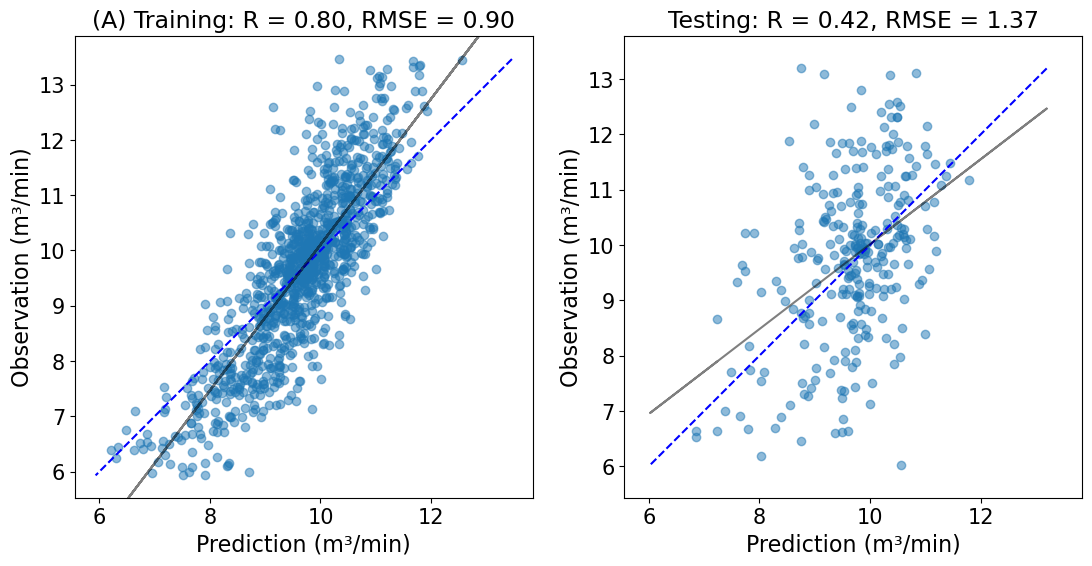

In [17]:
##PLot the results
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

# Calculate RMSE and R^2 values for training data
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r_train = np.sqrt(r2_score(y_train, y_train_pred))

# Calculate RMSE and R^2 values for testing data
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r_test = np.sqrt(r2_score(y_test, y_pred))


##############   FIGURE  VISUALISATION  ##################
fig, (ax2,ax1)=plt.subplots(1,2,figsize=(13, 6),sharex=True)

ax2.scatter(y_train_pred, y_train, alpha = 0.5)

p1 = max(max(y_train_pred), np.max(y_train)[0])
p2 = min(min(y_train_pred), np.min(y_train)[0])
ax2.plot([p1,p2], [p1, p2], 'b--')


m2, b2 = np.polyfit(y_train_pred, y_train, 1)
ax2.plot(y_train, m2 * y_train + b2, color='k',linestyle='-', alpha = 0.5)

ax2.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax2.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax2.axis('equal')
ax2.set_title(f'(A) Training: R = {r_train:.2f}, RMSE = {rmse_train:.2f}' ,fontsize=17)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)


ax1.scatter(y_pred, y_test,alpha = 0.5)
p1 = max(max(y_pred), np.max(y_test)[0])
p2 = min(min(y_pred), np.min(y_test)[0])
ax1.plot([p1, p2], [p1, p2], 'b--')

m1, b1 = np.polyfit(y_pred, y_test, 1)
ax1.plot(y_test, m1 * y_test + b1, color='k',linestyle='-', alpha = 0.5)

ax1.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax1.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax1.axis('equal')
ax1.set_title(f'Testing: R = {r_test:.2f}, RMSE = {rmse_test:.2f}' ,fontsize=17)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)




fig.show()



C:\Programs\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Programs\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Programs\Anaconda3\TEMP\ipykernel_14640\1946205605.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


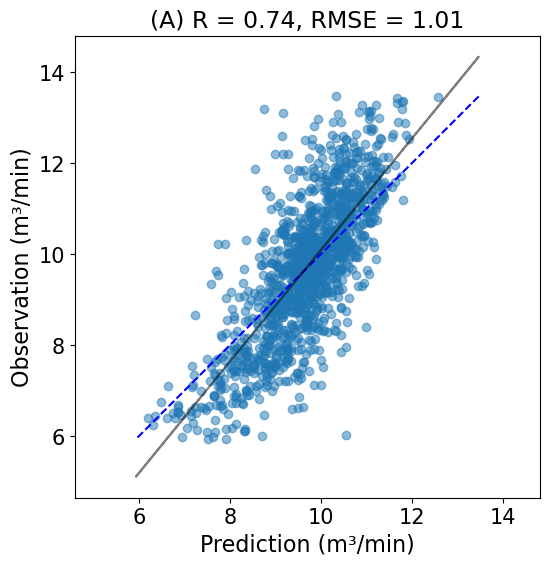

In [20]:
##PLot the results
y_pred_total = regressor.predict(X1)


# Calculate RMSE and R^2 values for training data
rmse_total = np.sqrt(mean_squared_error(y, y_pred_total))
r_total = np.sqrt(r2_score(y, y_pred_total))



##############   FIGURE  VISUALISATION  ##################
fig, (ax2)=plt.subplots(figsize=(6, 6),sharex=True)

ax2.scatter(y_pred_total, y, alpha = 0.5)

p1 = max(max(y_pred_total), np.max(y)[0])
p2 = min(min(y_pred_total), np.min(y)[0])
ax2.plot([p1,p2], [p1, p2], 'b--')


m2, b2 = np.polyfit(y_pred_total, y, 1)
ax2.plot(y, m2 * y + b2, color='k',linestyle='-', alpha = 0.5)

ax2.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax2.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax2.axis('equal')
ax2.set_title(f'(A) R = {r_total:.2f}, RMSE = {rmse_total:.2f}' ,fontsize=17)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

fig.show()



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


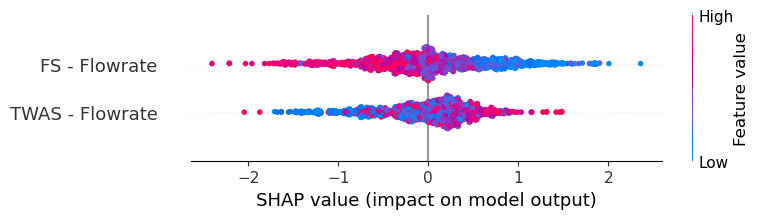

<Figure size 640x480 with 0 Axes>

In [21]:
# SHAP Analysis
import shap
custom_feature_names = ["FS - Flowrate",  "TWAS - Flowrate"]  # Replace with your actual feature names


explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X1)

# Summary plot
shap.summary_plot(shap_values, X1, feature_names=custom_feature_names)
plt.savefig('shap_summary_plot.png', dpi=1000, bbox_inches='tight')

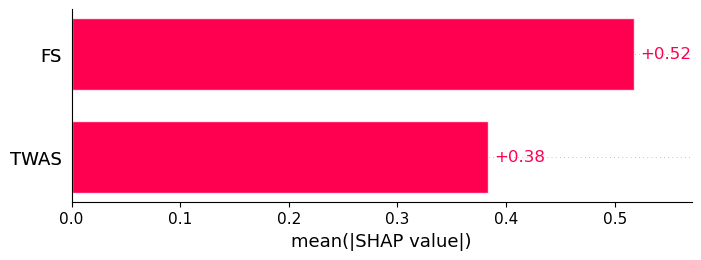

In [22]:
# Create the TreeExplainer and compute SHAP values
explainer = shap.Explainer(regressor)
shap_values = explainer(X1)

# Now shap_values is an Explanation object, which can be directly used with plotting functions
shap.plots.bar(shap_values)

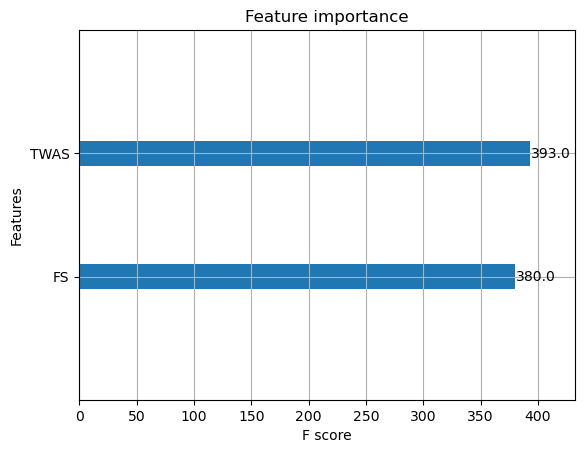

In [24]:
xgb.plot_importance(regressor)
plt.show()

###  BAYESIAN Optimization for XGBoost model to determine the optimum values for FS and TWAS when biogas productoin rate is above 10 m^3/min.

In [735]:

def predict_xgboost(FS, TWAS):
    # Load the pre-trained XGBoost model
    ###xgb_model = xgb.Booster()
    ###xgb_model.load_model("xgboost.model")
    
    # Prepare the input data for the model
    data = pd.DataFrame({'FS': FS,
                      'TWAS': TWAS}, index=[0])
    
    
    input_data = xgb.DMatrix(data)
    
    # Make the prediction
    prediction = regressor.predict(data)[0]#(input_data)[0]
    
    return prediction

pbounds = {'FS': (0.53,8.94),'TWAS': (2.4,11.03)}
optimizer = BayesianOptimization(f=predict_xgboost, pbounds=pbounds)
# Optimize the black box function
optimizer.maximize(init_points=5,n_iter=1500)

results_df = pd.DataFrame(optimizer.res, columns=['params', 'target'])
print(optimizer.max)
#print("Maximum:", optimizer.res['max']['max_val'])
#print("Optimal parameters:", optimizer.res['max']['max_params'])


# Optimization results in a dataframe

results_df_df = pd.DataFrame(optimizer.res, columns=['params', 'target'])



def extract_params(params_dict):
    x = params_dict['FS']
    y = params_dict['TWAS']

    return x, y

# Apply the extract_params function to the 'params' column
results_df_df[['FS', 'TWAS']] = results_df_df['params'].apply(extract_params).apply(pd.Series)

# Drop the 'params' column
results_df_df.drop('params', axis=1, inplace=True)

results_df_df

|   iter    |  target   |    FS     |   TWAS    |
-------------------------------------------------
| 1         | 10.43     | 4.708     | 3.705     |
| 2         | 10.27     | 2.088     | 5.503     |
| 3         | 9.536     | 4.673     | 3.601     |
| 4         | 9.435     | 4.358     | 5.759     |
| 5         | 7.905     | 7.062     | 9.453     |
| 6         | 10.49     | 4.813     | 3.737     |
| 7         | 9.882     | 4.689     | 3.926     |
| 8         | 10.17     | 4.668     | 3.7       |
| 9         | 10.57     | 2.366     | 5.549     |
| 10        | 10.36     | 2.257     | 5.765     |
| 11        | 10.66     | 2.582     | 5.692     |
| 12        | 10.08     | 2.632     | 5.444     |
| 13        | 11.33     | 3.957     | 4.655     |
| 14        | 11.54     | 3.788     | 4.673     |
| 15        | 10.92     | 3.788     | 10.73     |
| 16        | 10.29     | 3.854     | 4.866     |
| 17        | 10.46     | 3.62      | 8.02      |
| 18        | 11.13     | 3.808     | 4.512     |


| 101       | 12.59     | 3.281     | 2.414     |
| 102       | 12.47     | 3.542     | 2.457     |
| 103       | 12.59     | 2.816     | 2.42      |
| 104       | 12.59     | 2.574     | 2.493     |
| 105       | 12.59     | 2.349     | 2.4       |
| 106       | 11.7      | 2.337     | 2.645     |
| 107       | 12.59     | 2.074     | 2.4       |
| 108       | 12.59     | 1.844     | 2.462     |
| 109       | 11.7      | 2.014     | 2.656     |
| 110       | 12.59     | 1.56      | 2.423     |
| 111       | 12.18     | 1.606     | 2.603     |
| 112       | 12.59     | 1.282     | 2.512     |
| 113       | 12.59     | 1.037     | 2.401     |
| 114       | 11.7      | 1.027     | 2.633     |
| 115       | 12.59     | 0.7175    | 2.4       |
| 116       | 11.7      | 0.6104    | 2.69      |
| 117       | 10.3      | 2.525     | 5.999     |
| 118       | 12.32     | 3.886     | 2.45      |
| 119       | 11.69     | 4.227     | 2.448     |
| 120       | 11.47     | 3.91      | 2.735     |


| 201       | 11.02     | 3.448     | 5.61      |
| 202       | 10.45     | 3.992     | 6.259     |
| 203       | 9.225     | 7.788     | 5.224     |
| 204       | 11.83     | 3.459     | 3.189     |
| 205       | 10.15     | 8.341     | 8.852     |
| 206       | 11.34     | 3.28      | 4.699     |
| 207       | 9.943     | 3.214     | 6.965     |
| 208       | 12.59     | 2.761     | 2.557     |
| 209       | 10.58     | 1.158     | 6.302     |
| 210       | 10.15     | 8.37      | 9.566     |
| 211       | 10.78     | 7.241     | 4.99      |
| 212       | 6.851     | 4.967     | 11.03     |
| 213       | 10.32     | 0.5498    | 8.349     |
| 214       | 6.851     | 4.97      | 9.37      |
| 215       | 10.82     | 3.943     | 9.752     |
| 216       | 11.12     | 8.606     | 5.521     |
| 217       | 10.32     | 1.677     | 9.272     |
| 218       | 10.32     | 1.05      | 10.41     |
| 219       | 11.29     | 2.569     | 2.856     |
| 220       | 10.46     | 4.705     | 4.975     |


| 301       | 12.59     | 0.8997    | 2.478     |
| 302       | 12.59     | 2.88      | 2.5       |
| 303       | 9.171     | 5.903     | 4.756     |
| 304       | 10.32     | 2.075     | 11.03     |
| 305       | 10.32     | 1.505     | 9.701     |
| 306       | 9.839     | 5.812     | 5.679     |
| 307       | 11.7      | 3.492     | 2.616     |
| 308       | 9.856     | 5.049     | 4.653     |
| 309       | 11.7      | 3.177     | 2.691     |
| 310       | 12.59     | 3.277     | 2.496     |
| 311       | 6.957     | 7.585     | 7.409     |
| 312       | 9.794     | 4.87      | 5.371     |
| 313       | 8.277     | 7.203     | 5.478     |
| 314       | 9.758     | 7.163     | 4.643     |
| 315       | 11.12     | 8.372     | 5.249     |
| 316       | 10.06     | 1.837     | 7.462     |
| 317       | 10.58     | 3.605     | 9.458     |
| 318       | 11.7      | 4.589     | 3.021     |
| 319       | 10.8      | 2.032     | 3.343     |
| 320       | 12.59     | 2.094     | 2.481     |


| 401       | 10.33     | 0.53      | 6.602     |
| 402       | 9.943     | 1.738     | 7.054     |
| 403       | 12.59     | 1.68      | 2.491     |
| 404       | 12.05     | 3.859     | 2.4       |
| 405       | 6.841     | 5.667     | 11.03     |
| 406       | 10.89     | 4.568     | 4.601     |
| 407       | 10.32     | 2.67      | 10.64     |
| 408       | 10.32     | 0.8089    | 8.627     |
| 409       | 10.22     | 8.57      | 4.163     |
| 410       | 9.256     | 6.883     | 4.118     |
| 411       | 10.83     | 3.264     | 11.03     |
| 412       | 10.15     | 8.542     | 9.214     |
| 413       | 10.8      | 3.277     | 4.862     |
| 414       | 12.59     | 1.805     | 2.585     |
| 415       | 12.59     | 2.972     | 2.416     |
| 416       | 12.59     | 1.636     | 2.4       |
| 417       | 8.354     | 7.116     | 9.36      |
| 418       | 10.84     | 4.903     | 2.4       |
| 419       | 9.988     | 8.157     | 4.309     |
| 420       | 8.219     | 6.091     | 3.989     |


| 501       | 10.32     | 1.96      | 9.049     |
| 502       | 12.59     | 0.9518    | 2.4       |
| 503       | 10.91     | 0.8893    | 4.414     |
| 504       | 12.59     | 1.121     | 2.435     |
| 505       | 10.32     | 0.7633    | 10.22     |
| 506       | 12.59     | 0.7154    | 2.511     |
| 507       | 12.59     | 2.68      | 2.509     |
| 508       | 12.32     | 3.965     | 2.495     |
| 509       | 12.59     | 1.765     | 2.459     |
| 510       | 9.046     | 6.567     | 9.132     |
| 511       | 12.59     | 2.152     | 2.403     |
| 512       | 12.4      | 3.64      | 2.468     |
| 513       | 12.59     | 1.801     | 2.4       |
| 514       | 12.59     | 0.5946    | 2.581     |
| 515       | 12.59     | 2.917     | 2.578     |
| 516       | 9.983     | 5.66      | 5.333     |
| 517       | 12.59     | 0.6235    | 2.534     |
| 518       | 12.59     | 3.451     | 2.429     |
| 519       | 12.59     | 1.667     | 2.446     |
| 520       | 12.59     | 0.8493    | 2.519     |


| 601       | 9.943     | 0.9347    | 7.087     |
| 602       | 10.33     | 2.266     | 6.593     |
| 603       | 8.847     | 5.045     | 6.525     |
| 604       | 10.15     | 3.045     | 6.394     |
| 605       | 12.59     | 2.134     | 2.473     |
| 606       | 12.59     | 2.728     | 2.546     |
| 607       | 12.59     | 2.531     | 2.467     |
| 608       | 10.68     | 3.676     | 5.3       |
| 609       | 10.3      | 1.863     | 5.976     |
| 610       | 10.36     | 1.874     | 5.744     |
| 611       | 8.825     | 7.852     | 10.02     |
| 612       | 9.739     | 3.776     | 7.293     |
| 613       | 12.59     | 0.5322    | 2.546     |
| 614       | 10.54     | 2.334     | 5.228     |
| 615       | 10.15     | 8.624     | 10.81     |
| 616       | 10.32     | 0.7703    | 9.205     |
| 617       | 11.02     | 0.8082    | 3.967     |
| 618       | 10.47     | 2.945     | 3.648     |
| 619       | 10.36     | 1.42      | 5.765     |
| 620       | 7.561     | 5.524     | 9.542     |


| 701       | 10.27     | 0.53      | 5.214     |
| 702       | 8.377     | 8.94      | 2.879     |
| 703       | 10.11     | 8.031     | 7.282     |
| 704       | 10.32     | 0.53      | 8.651     |
| 705       | 11.24     | 2.231     | 4.045     |
| 706       | 8.636     | 7.73      | 8.7       |
| 707       | 11.49     | 2.887     | 4.222     |
| 708       | 8.206     | 5.681     | 3.048     |
| 709       | 10.03     | 4.761     | 5.781     |
| 710       | 10.32     | 2.925     | 9.637     |
| 711       | 11.78     | 2.404     | 3.306     |
| 712       | 10.47     | 0.6989    | 3.682     |
| 713       | 9.363     | 7.846     | 3.928     |
| 714       | 10.06     | 3.241     | 7.477     |
| 715       | 9.795     | 8.532     | 3.736     |
| 716       | 11.01     | 3.525     | 5.285     |
| 717       | 10.38     | 5.01      | 5.045     |
| 718       | 10.74     | 4.006     | 4.274     |
| 719       | 9.043     | 6.181     | 5.465     |
| 720       | 10.82     | 3.958     | 10.03     |


| 801       | 10.22     | 4.065     | 5.137     |
| 802       | 8.569     | 5.303     | 7.823     |
| 803       | 10.91     | 7.914     | 5.747     |
| 804       | 9.617     | 7.847     | 5.992     |
| 805       | 11.41     | 3.415     | 4.374     |
| 806       | 10.44     | 1.121     | 8.066     |
| 807       | 8.354     | 7.129     | 9.939     |
| 808       | 10.32     | 2.08      | 9.299     |
| 809       | 10.32     | 0.53      | 10.27     |
| 810       | 10.71     | 2.431     | 4.447     |
| 811       | 10.23     | 2.691     | 4.798     |
| 812       | 11.11     | 3.904     | 6.545     |
| 813       | 8.636     | 7.754     | 9.837     |
| 814       | 10.54     | 2.936     | 5.334     |
| 815       | 10.32     | 2.15      | 8.814     |
| 816       | 10.27     | 8.346     | 7.063     |
| 817       | 10.47     | 2.564     | 3.679     |
| 818       | 10.29     | 0.7695    | 8.127     |
| 819       | 10.32     | 1.739     | 9.583     |
| 820       | 10.46     | 4.541     | 5.457     |


| 901       | 10.32     | 1.251     | 8.904     |
| 902       | 11.7      | 2.478     | 2.697     |
| 903       | 10.15     | 8.299     | 8.601     |
| 904       | 10.36     | 3.088     | 3.492     |
| 905       | 11.24     | 2.915     | 2.898     |
| 906       | 11.42     | 1.992     | 5.864     |
| 907       | 9.943     | 2.815     | 7.063     |
| 908       | 11.91     | 4.123     | 2.4       |
| 909       | 10.57     | 3.598     | 5.494     |
| 910       | 6.841     | 5.668     | 9.31      |
| 911       | 11.78     | 1.805     | 3.304     |
| 912       | 10.36     | 1.792     | 3.487     |
| 913       | 10.58     | 3.724     | 10.48     |
| 914       | 7.625     | 4.881     | 7.691     |
| 915       | 12.59     | 2.348     | 2.532     |
| 916       | 10.06     | 0.8261    | 7.35      |
| 917       | 10.15     | 8.657     | 11.03     |
| 918       | 11.29     | 3.089     | 2.82      |
| 919       | 10.92     | 3.529     | 9.157     |
| 920       | 10.32     | 2.506     | 9.575     |


| 1001      | 11.85     | 3.986     | 2.604     |
| 1002      | 12.32     | 3.89      | 2.507     |
| 1003      | 10.32     | 1.754     | 8.22      |
| 1004      | 10.68     | 3.806     | 3.548     |
| 1005      | 11.88     | 4.204     | 2.584     |
| 1006      | 10.82     | 3.108     | 3.944     |
| 1007      | 10.32     | 2.84      | 10.8      |
| 1008      | 10.32     | 3.062     | 10.17     |
| 1009      | 11.7      | 3.379     | 2.742     |
| 1010      | 10.32     | 1.598     | 10.76     |
| 1011      | 10.15     | 8.755     | 9.325     |
| 1012      | 10.27     | 4.627     | 3.141     |
| 1013      | 10.44     | 3.858     | 10.89     |
| 1014      | 10.51     | 4.375     | 3.123     |
| 1015      | 11.24     | 1.252     | 2.979     |
| 1016      | 10.23     | 1.753     | 4.797     |
| 1017      | 10.37     | 4.246     | 4.206     |
| 1018      | 10.56     | 2.092     | 3.602     |
| 1019      | 10.32     | 1.019     | 9.208     |
| 1020      | 6.91      | 5.955     | 10.55     |


| 1101      | 12.59     | 1.055     | 2.43      |
| 1102      | 10.12     | 4.322     | 5.801     |
| 1103      | 8.817     | 4.404     | 6.013     |
| 1104      | 10.77     | 8.839     | 6.343     |
| 1105      | 12.59     | 2.606     | 2.428     |
| 1106      | 10.32     | 2.17      | 10.13     |
| 1107      | 12.59     | 1.022     | 2.537     |
| 1108      | 12.59     | 0.8851    | 2.517     |
| 1109      | 12.59     | 1.19      | 2.426     |
| 1110      | 12.59     | 3.118     | 2.42      |
| 1111      | 9.48      | 5.096     | 3.663     |
| 1112      | 12.59     | 2.21      | 2.528     |
| 1113      | 12.59     | 1.88      | 2.436     |
| 1114      | 6.854     | 5.025     | 10.57     |
| 1115      | 11.09     | 5.51      | 7.6       |
| 1116      | 10.32     | 2.425     | 10.56     |
| 1117      | 12.59     | 2.519     | 2.421     |
| 1118      | 12.59     | 1.206     | 2.536     |
| 1119      | 10.15     | 8.397     | 10.72     |
| 1120      | 12.59     | 2.711     | 2.413     |


| 1201      | 10.32     | 2.423     | 8.455     |
| 1202      | 11.13     | 3.959     | 4.484     |
| 1203      | 12.59     | 3.191     | 2.431     |
| 1204      | 12.59     | 2.773     | 2.46      |
| 1205      | 10.32     | 0.7723    | 8.385     |
| 1206      | 12.59     | 1.948     | 2.437     |
| 1207      | 12.59     | 2.836     | 2.492     |
| 1208      | 10.68     | 3.877     | 5.128     |
| 1209      | 12.59     | 3.472     | 2.52      |
| 1210      | 12.59     | 1.415     | 2.43      |
| 1211      | 12.59     | 2.326     | 2.433     |
| 1212      | 11.11     | 5.011     | 3.3       |
| 1213      | 10.59     | 3.585     | 6.761     |
| 1214      | 12.59     | 1.827     | 2.569     |
| 1215      | 10.44     | 2.74      | 8.046     |
| 1216      | 12.59     | 3.094     | 2.578     |
| 1217      | 12.59     | 3.078     | 2.539     |
| 1218      | 12.18     | 2.504     | 2.598     |
| 1219      | 12.59     | 2.588     | 2.552     |
| 1220      | 9.683     | 8.27      | 6.662     |


| 1301      | 9.518     | 6.763     | 9.888     |
| 1302      | 10.15     | 8.71      | 8.225     |
| 1303      | 12.59     | 0.5591    | 2.464     |
| 1304      | 12.51     | 3.928     | 2.553     |
| 1305      | 11.83     | 2.741     | 3.229     |
| 1306      | 11.24     | 2.68      | 3.083     |
| 1307      | 12.59     | 2.533     | 2.4       |
| 1308      | 11.13     | 3.756     | 5.908     |
| 1309      | 10.53     | 4.035     | 5.924     |
| 1310      | 12.59     | 1.462     | 2.488     |
| 1311      | 8.214     | 7.081     | 10.6      |
| 1312      | 12.59     | 1.831     | 2.498     |
| 1313      | 12.59     | 3.436     | 2.514     |
| 1314      | 12.59     | 0.53      | 2.57      |
| 1315      | 8.786     | 4.459     | 7.223     |
| 1316      | 10.32     | 0.5767    | 9.736     |
| 1317      | 8.74      | 6.938     | 10.14     |
| 1318      | 12.59     | 1.462     | 2.4       |
| 1319      | 11.51     | 4.137     | 7.934     |
| 1320      | 9.17      | 3.965     | 7.794     |


| 1401      | 12.59     | 3.045     | 2.51      |
| 1402      | 12.59     | 2.917     | 2.412     |
| 1403      | 10.58     | 3.73      | 9.669     |
| 1404      | 10.27     | 8.803     | 7.172     |
| 1405      | 12.18     | 2.199     | 2.604     |
| 1406      | 10.61     | 0.9455    | 5.153     |
| 1407      | 10.32     | 1.407     | 10.61     |
| 1408      | 10.77     | 4.713     | 5.576     |
| 1409      | 9.829     | 0.912     | 7.529     |
| 1410      | 11.26     | 4.51      | 2.631     |
| 1411      | 11.62     | 2.143     | 3.234     |
| 1412      | 12.59     | 3.122     | 2.4       |
| 1413      | 10.15     | 0.5341    | 6.399     |
| 1414      | 10.27     | 8.138     | 7.107     |
| 1415      | 10.95     | 1.511     | 4.59      |
| 1416      | 12.59     | 2.153     | 2.525     |
| 1417      | 10.91     | 4.078     | 9.857     |
| 1418      | 12.59     | 1.456     | 2.566     |
| 1419      | 9.854     | 4.664     | 9.11      |
| 1420      | 10.57     | 3.404     | 4.608     |


| 1501      | 10.32     | 1.442     | 9.101     |
| 1502      | 9.718     | 6.6       | 5.871     |
| 1503      | 10.62     | 5.51      | 4.939     |
| 1504      | 10.15     | 8.703     | 9.842     |
| 1505      | 9.152     | 8.189     | 7.773     |
{'target': 12.592270851135254, 'params': {'FS': 3.0516256746866413, 'TWAS': 2.4362869808288496}}


,target,FS,TWAS
0,10.434118,4.707737,3.705393
1,10.266174,2.088418,5.503217
2,9.536286,4.672747,3.600648
3,9.435231,4.357894,5.758923
4,7.904929,7.062172,9.452668
...,...,...,...
1500,10.323380,1.442229,9.100517
1501,9.717710,6.599544,5.871217
1502,10.617616,5.509804,4.939200
1503,10.153500,8.702987,9.841532


#### Visualizatoin of optimization results

In [745]:
####    DAtaframe for the biogas production rates above 10 m^3/min

## A dataframe with Biogas > 10
new_results_df_df = results_df_df[results_df_df['target'] > 10]
new_results_df_df.reset_index(drop=True,inplace = True)

new_results_df_df

# add new columns to new dataframe
new_results_df_df = new_results_df_df.assign(FS_percent =new_results_df_df['FS']/(new_results_df_df['TWAS']+
                                       new_results_df_df['FS']),
                                       TWAS_percent =new_results_df_df['TWAS']/(new_results_df_df['TWAS']+
                                       new_results_df_df['FS']))
new_results_df_df = new_results_df_df.assign(FS_to_TWAS =new_results_df_df['FS']/(new_results_df_df['TWAS']))


new_results_df_df ###Mixing ratios




,target,FS,TWAS,FS_percent,TWAS_percent,FS_to_TWAS
0,10.434118,4.707737,3.705393,0.559570,0.440430,1.270510
1,10.266174,2.088418,5.503217,0.275095,0.724905,0.379490
2,10.490979,4.812566,3.736529,0.562933,0.437067,1.287978
3,10.173528,4.668007,3.700209,0.557826,0.442174,1.261552
4,10.567196,2.365926,5.549452,0.298902,0.701098,0.426335
...,...,...,...,...,...,...
1220,10.154337,2.435858,6.415022,0.275211,0.724789,0.379712
1221,12.590358,3.700637,2.541927,0.592807,0.407193,1.455839
1222,10.323380,1.442229,9.100517,0.136798,0.863202,0.158478
1223,10.617616,5.509804,4.939200,0.527304,0.472696,1.115526


In [746]:
new_results_df_df.describe()

,target,FS,TWAS,FS_percent,TWAS_percent,FS_to_TWAS
count,1225.000000,1225.000000,1225.000000,1225.000000,1225.000000,1225.000000
mean,11.390404,3.011683,4.886454,0.380822,0.619178,0.726396
std,0.986818,2.121653,2.785410,0.155198,0.155198,0.460795
min,10.031889,0.530000,2.400000,0.045848,0.310755,0.048051
25%,10.380761,1.510942,2.521256,0.254365,0.490469,0.341138
50%,11.199064,2.575151,3.821601,0.390411,0.609589,0.640450
75%,12.592271,3.625513,6.602018,0.509531,0.745635,1.038867
max,12.592271,8.940000,11.030000,0.689245,0.954152,2.217967


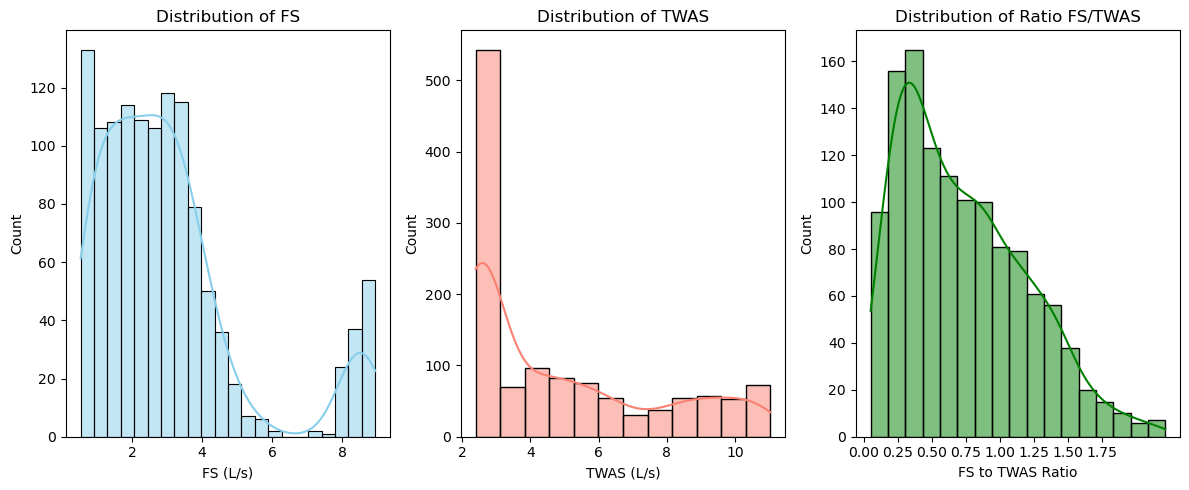

In [748]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.histplot(new_results_df_df['FS'], kde=True, color='skyblue')
plt.title('Distribution of FS')
plt.xlabel('FS (L/s)')


plt.subplot(1, 3, 2)
sns.histplot(new_results_df_df['TWAS'], kde=True, color='salmon')
plt.title('Distribution of TWAS')
plt.xlabel('TWAS (L/s)')


plt.subplot(1, 3, 3)
sns.histplot(new_results_df_df['FS_to_TWAS'], kde=True, color='green')
plt.title('Distribution of Ratio FS/TWAS')
plt.xlabel('FS to TWAS Ratio')
plt.xticks(np.arange(0, 2, 0.25))

plt.tight_layout()
plt.show()

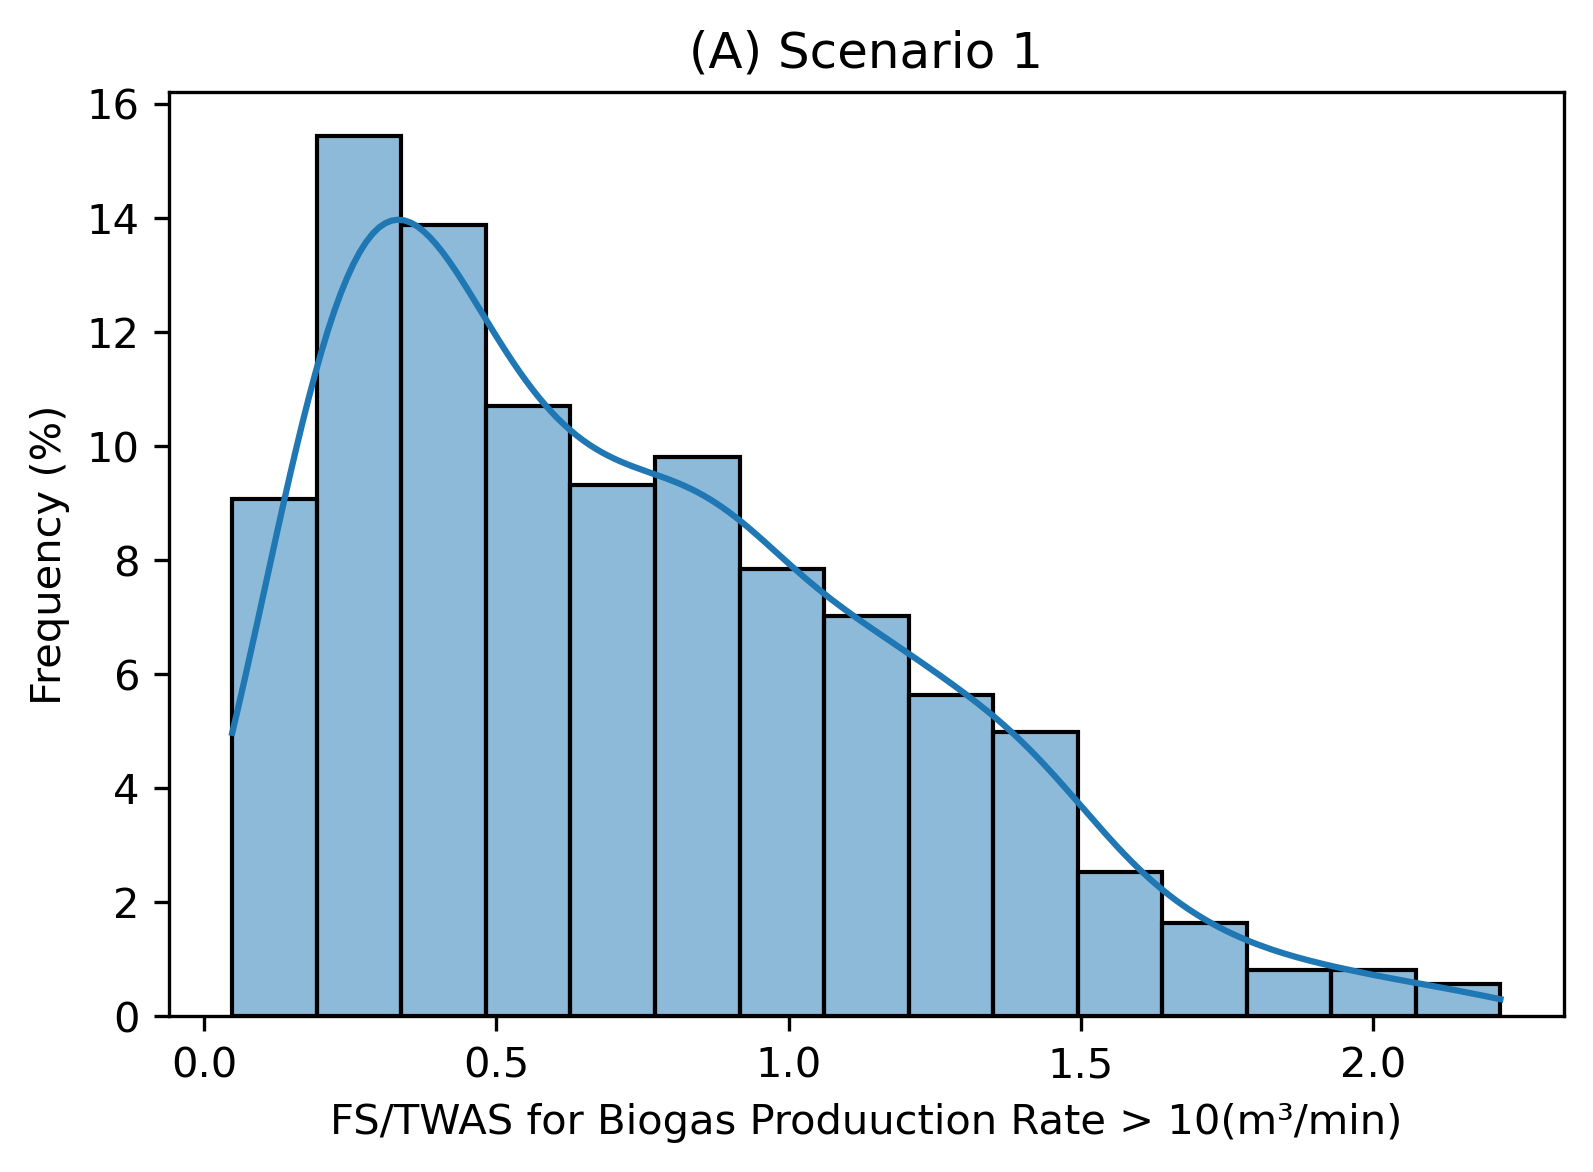

In [759]:
# Plot the histogram
# Increase figure size and set higher DPI
plt.figure(figsize=(6, 4), dpi=300)
sns.histplot(new_results_df_df['FS_to_TWAS'], bins=15, kde=True,  stat='percent')
plt.title('(A) Scenario 1')
plt.xlabel('FS/TWAS for Biogas Produuction Rate > 10(m\u00b3/min)')
plt.ylabel('Frequency (%)')
plt.grid(False)
plt.show()

# (B) Scenario 2: Biogas from quntity and quality data

In [4]:
FS=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_November_2023_USE.xlsx"
                   ,sheet_name="FS_Quality")
TWAS=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_November_2023_USE.xlsx"
                   ,sheet_name="TWAS_Quality")

Biogas=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_November_2023_USE.xlsx"
                   ,sheet_name="BiogasFlow")
Biogas_flow=Biogas[['TimeStamp','DailyAverageBiogasFlowfromDigesters_m3permin']]


Sludge_flow=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_November_2023_USE.xlsx"
                   ,sheet_name="DigesterInflow")
FS_flow=Sludge_flow[['TimeStamp','DailyAverageFSFlow_L/s']]
TWAS_flow=Sludge_flow[['TimeStamp','DailyAverageTWASFlowtoDigesters_L/s']]

## 1. Normality Test

In [5]:
FS1 = FS.copy()
FS1 = FS1.drop('Phosphorus, Total', axis=1)
FS1 = FS1.dropna()

TWAS1 = TWAS.copy()
TWAS1 = TWAS1.drop('Phosphorus, Total', axis=1)
TWAS1 = TWAS1.dropna()

## NORMALITY TEST for FS
columns_to_check_FS = ['pH @ 25°C','Solids, Fixed','Solids, Total','Solids, Volatile','Temperature']
for column in columns_to_check_FS:
    #Shapiro-Wilk test
    stat,p=shapiro(FS1[column])
    print (f"FS Shapiro-Wilk Test for {column}- p-value:",p)

FS Shapiro-Wilk Test for pH @ 25°C- p-value: 7.441837078658864e-05
FS Shapiro-Wilk Test for Solids, Fixed- p-value: 6.041249913427865e-40
FS Shapiro-Wilk Test for Solids, Total- p-value: 5.9940261551801185e-40
FS Shapiro-Wilk Test for Solids, Volatile- p-value: 5.992358610007572e-40
FS Shapiro-Wilk Test for Temperature- p-value: 1.927819084812654e-06


If the p-value < 0.05 in the Shapiro-Wilk test, it suggests that the data significantly deviates from a normal distribution.
Therefore non-normal values are pH, VS, FS, and temperature.


In [10]:
## NORMALITY TEST for TWAS
columns_to_check_TWAS = ['Solids, Fixed','Solids, Total','Solids, Volatile']
for column in columns_to_check_TWAS:
    #Shapiro-Wilk test
    stat,p=shapiro(TWAS1[column])
    print (f"TWAS Shapiro-Wilk Test for {column}- p-value:",p)

TWAS Shapiro-Wilk Test for Solids, Fixed- p-value: 1.3317744551977098e-25
TWAS Shapiro-Wilk Test for Solids, Total- p-value: 1.2620019268022072e-25
TWAS Shapiro-Wilk Test for Solids, Volatile- p-value: 1.3056445470479117e-25


Therefore non-normal values are FS, VS, TS, and temperature

In [11]:
### CORRELATION TEST  ###

## Function for SPERMAN Correlation 
def spearman_correlation (dataframe):
    r, pval = stats.spearmanr(dataframe,axis=0)
    return r, pval

####  FS   ####
r, pval = spearman_correlation(FS1[columns_to_check_FS]) 

# Create DataFrames for correlation coefficients and p-values
correlation_results_FS = pd.DataFrame(data=r, columns=columns_to_check_FS, index=columns_to_check_FS)
pvalue_results_FS = pd.DataFrame(data=pval, columns=columns_to_check_FS, index=columns_to_check_FS)

# Print the combined results
print("FS Spearman correlation:")
print (correlation_results_FS)
print ("")
print ("")
print("FS Spearman P-Values:")
print (pvalue_results_FS)

FS Spearman correlation:
                  pH @ 25°C  Solids, Fixed  Solids, Total  Solids, Volatile  \
pH @ 25°C          1.000000      -0.271634      -0.284373         -0.255646   
Solids, Fixed     -0.271634       1.000000       0.855568          0.643216   
Solids, Total     -0.284373       0.855568       1.000000          0.932892   
Solids, Volatile  -0.255646       0.643216       0.932892          1.000000   
Temperature       -0.383754       0.026223       0.026793          0.007907   

                  Temperature  
pH @ 25°C           -0.383754  
Solids, Fixed        0.026223  
Solids, Total        0.026793  
Solids, Volatile     0.007907  
Temperature          1.000000  


FS Spearman P-Values:
                     pH @ 25°C  Solids, Fixed  Solids, Total  \
pH @ 25°C         0.000000e+00   2.112824e-08   4.194015e-09   
Solids, Fixed     2.112824e-08   0.000000e+00  2.701030e-119   
Solids, Total     4.194015e-09  2.701030e-119   0.000000e+00   
Solids, Volatile  1.433064e-

# 

In [13]:
### CORRELATION TEST  ###
TWAS1 = TWAS1.dropna()

####  TWAS   ####
r, pval = spearman_correlation(TWAS[columns_to_check_TWAS]) 

# Create DataFrames for correlation coefficients and p-values
correlation_results_TWAS = pd.DataFrame(data=r, columns=columns_to_check_TWAS, index=columns_to_check_TWAS)
pvalue_results_TWAS = pd.DataFrame(data=pval, columns=columns_to_check_TWAS, index=columns_to_check_TWAS)

# Print the combined results
# Print the combined results
print("TWAS Spearman correlation:")
print (correlation_results_TWAS)
print ("")
print ("")
print("TWAS Spearman P-Values:")
print (pvalue_results_TWAS)

TWAS Spearman correlation:
                  Solids, Fixed  Solids, Total  Solids, Volatile
Solids, Fixed          1.000000       0.267040         -0.441619
Solids, Total          0.267040       1.000000          0.685547
Solids, Volatile      -0.441619       0.685547          1.000000


TWAS Spearman P-Values:
                  Solids, Fixed  Solids, Total  Solids, Volatile
Solids, Fixed      0.000000e+00   1.166570e-03      2.692898e-08
Solids, Total      1.166570e-03   0.000000e+00      1.868034e-21
Solids, Volatile   2.692898e-08   1.868034e-21      0.000000e+00


## 2. Dataframe for Sludge Flows (FS_flow, TWAS_Flow) + Quality Parameters (FS1, TWAS1) + Biogas (Biogas_flow)

In [14]:
FS1_1 = FS1.copy()
TWAS1_1 = TWAS1.copy()


In [15]:
###  "_FS" to specific columns
columns_to_rename = {'Row Labels':'Date','pH @ 25°C': 'pH_FS', 'Phosphorus, Total': 'P_FS','Solids, Volatile':'VS_FS',
                     'Temperature':'T_FS'}
FS1_1.rename(columns=columns_to_rename, inplace=True)

columns_to_remove = ['Solids, Fixed', 'Solids, Total']
FS1_1.drop(columns=columns_to_remove, inplace=True)

# Extract only the date part (removing the time portion) from 'Date' column in FS1_1 DataFrame
FS1_1['Date'] = FS1_1['Date'].dt.date
FS1_1['Date'] = pd.to_datetime(FS1_1['Date'])


columns_to_rename = {'TimeStamp':'Date','DailyAverageFSFlow_L/s': 'FS_flow'}
FS_flow.rename(columns=columns_to_rename, inplace=True)
FS_flow['Date'] = pd.to_datetime(FS_flow['Date'])



C:\Programs\Anaconda3\TEMP\ipykernel_6416\2472462338.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FS_flow.rename(columns=columns_to_rename, inplace=True)
C:\Programs\Anaconda3\TEMP\ipykernel_6416\2472462338.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FS_flow['Date'] = pd.to_datetime(FS_flow['Date'])


## 

In [16]:
###  "_TWAS" to specific columns
columns_to_rename = {'Row Labels':'Date', 'Phosphorus, Total': 'P_TWAS','Solids, Volatile':'VS_TWAS'}
TWAS1_1.rename(columns=columns_to_rename, inplace=True)

columns_to_remove = ['Solids, Fixed', 'Solids, Total']
TWAS1_1.drop(columns=columns_to_remove, inplace=True)

# Extract only the date part (removing the time portion) from 'Date' column in FS1_1 DataFrame
TWAS1_1['Date'] = TWAS1_1['Date'].dt.date
TWAS1_1['Date'] = pd.to_datetime(TWAS1_1['Date'])


columns_to_rename = {'TimeStamp':'Date','DailyAverageTWASFlowtoDigesters_L/s': 'TWAS_flow'}
TWAS_flow.rename(columns=columns_to_rename, inplace=True)
TWAS_flow['Date'] = pd.to_datetime(TWAS_flow['Date'])


C:\Programs\Anaconda3\TEMP\ipykernel_6416\732053249.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TWAS_flow.rename(columns=columns_to_rename, inplace=True)
C:\Programs\Anaconda3\TEMP\ipykernel_6416\732053249.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TWAS_flow['Date'] = pd.to_datetime(TWAS_flow['Date'])


In [17]:
###  "_BIOGAS" to specific columns
columns_to_rename = {'TimeStamp':'Date', 'DailyAverageBiogasFlowfromDigesters_m3permin': 'Biogas_flow'}
Biogas_flow.rename(columns=columns_to_rename, inplace=True)


# Extract only the date part (removing the time portion) from 'Date' column in FS1_1 DataFrame
Biogas_flow['Date'] = Biogas_flow['Date'].dt.date
Biogas_flow['Date'] = pd.to_datetime(Biogas_flow['Date'])



C:\Programs\Anaconda3\TEMP\ipykernel_6416\1852904094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Biogas_flow.rename(columns=columns_to_rename, inplace=True)
C:\Programs\Anaconda3\TEMP\ipykernel_6416\1852904094.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Biogas_flow['Date'] = Biogas_flow['Date'].dt.date
C:\Programs\Anaconda3\TEMP\ipykernel_6416\1852904094.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [40]:
merged_FS = pd.merge(FS1_1,FS_flow, on='Date', how='inner')
merged_FS.drop_duplicates(subset='Date', keep='first', inplace=True)


merged_TWAS = pd.merge(TWAS1_1,TWAS_flow, on='Date', how='inner')
merged_TWAS.drop_duplicates(subset='Date', keep='first', inplace=True)

# First, merge merged_TWAS and merged_FS based on 'Date'
merged_temp = pd.merge(merged_TWAS, merged_FS, on='Date', how='inner')
# Then, merge the result with Biogas_flow based on 'Date'
merged_Biogas = pd.merge(merged_temp, Biogas_flow, on='Date', how='inner')

## 3. Recursive Feature Elimination using XGBoost

In [66]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pandas as pd
import shap

In [67]:
X = merged_Biogas.iloc[:, 1:9]  # Columns 2, 3, 4, and 5
y = merged_Biogas.iloc[:, -1]   # Last column

# Specify features to be kept constant
constant_features = ['TWAS_flow', 'FS_flow','Biogas_flow']  # Replace 'Feature1' and 'Feature2' with your actual feature names

# Exclude constant features from the feature set
X = X.drop(columns=constant_features)



# Initialize XGBoost model
xgb_model = XGBRegressor()

# Specify the number of features to select (you can adjust this based on your preference)
num_features_to_select = 3  # Adjust the number of features you want to select

# Perform RFE on the training data
rfe = RFE(estimator=xgb_model, n_features_to_select=num_features_to_select)
rfe.fit(X, y)  # Use X_train and y_train for feature selection

# Get the selected features
selected_features = X.columns[rfe.support_]

# Evaluate model performance using cross-validation on the training data
scores = cross_val_score(estimator=xgb_model, X=X[selected_features], y=y, cv=5)  # Adjust the number of cross-validation folds as needed

# Print the selected features and their cross-validation scores
print("Selected Features:", selected_features)
print("Cross-Validation Scores:", scores)

# After selecting features and evaluating model performance, you can proceed to train and test your model on the test data (X_test, y_test).
# You can use the selected features for training and testing.

Selected Features: Index(['pH_FS', 'VS_FS', 'T_FS'], dtype='object')
Cross-Validation Scores: [-3.72981789 -2.20860273 -0.73854592 -2.99475635 -1.54068349]


Recursive Feature Elimination was used and indicated in addition to FS and TWAS inflow rates, I can use VS_TWAS and pH_FS, respectively. 

In [72]:
#XGBoost installation
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import DMatrix



from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import seaborn as sns
from scipy import stats
import statsmodels.api as sm


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV


In [74]:
######    ######   ######   #######   # ######    #######
FS1_2 = FS.copy()
columns_to_rename = {'Row Labels':'Date','pH @ 25°C': 'pH_FS', 'Phosphorus, Total': 'P_FS','Solids, Volatile':'VS_FS',
                     'Temperature':'T_FS'}
FS1_2.rename(columns=columns_to_rename, inplace=True)

columns_to_remove = ['Solids, Fixed', 'Solids, Total','P_FS']
FS1_2.drop(columns=columns_to_remove, inplace=True)

# Extract only the date part (removing the time portion) from 'Date' column in FS1_1 DataFrame
FS1_2['Date'] = FS1_2['Date'].dt.date
FS1_2['Date'] = pd.to_datetime(FS1_2['Date'])



###  "_TWAS" to specific columns ################   #####################   #####################
TWAS1_2 = TWAS.copy()
columns_to_rename = {'Row Labels':'Date', 'Phosphorus, Total': 'P_TWAS','Solids, Volatile':'VS_TWAS'}
TWAS1_2.rename(columns=columns_to_rename, inplace=True)

columns_to_remove = ['Solids, Fixed', 'Solids, Total','P_TWAS']
TWAS1_2.drop(columns=columns_to_remove, inplace=True)

# Extract only the date part (removing the time portion) from 'Date' column in FS1_1 DataFrame
TWAS1_2['Date'] = TWAS1_2['Date'].dt.date
TWAS1_2['Date'] = pd.to_datetime(TWAS1_2['Date'])


In [77]:
merged_FS1_2 = pd.merge(FS1_2,FS_flow, on='Date', how='inner')
merged_FS1_2.drop_duplicates(subset='Date', keep='first', inplace=True)


#merged_TWAS1_2 = pd.merge(TWAS1_2,TWAS_flow, on='Date', how='inner')
merged_TWAS1_2 = TWAS_flow
merged_TWAS1_2.drop_duplicates(subset='Date', keep='first', inplace=True)

# First, merge merged_TWAS and merged_FS based on 'Date'
merged_temp1_2 = pd.merge(merged_TWAS1_2, merged_FS1_2, on='Date', how='inner')
# Then, merge the result with Biogas_flow based on 'Date'
merged_Biogas1_2 = pd.merge(merged_temp1_2, Biogas_flow, on='Date', how='inner')
merged_Biogas1_2


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,TWAS_flow,pH_FS,VS_FS,T_FS,FS_flow,Biogas_flow
0,2018-05-10,8.333888,5.50,6.145,15.40,6.961020,5.170552
1,2018-05-15,7.837946,5.45,6.065,15.90,6.902504,7.386836
2,2018-05-22,9.141881,5.45,5.640,16.70,6.861444,5.579863
3,2018-05-24,7.152935,5.40,5.560,17.00,6.804641,4.817683
4,2018-05-28,7.520322,5.35,3.575,17.60,6.318137,4.532063
...,...,...,...,...,...,...,...
360,2022-03-31,6.291445,6.25,5.000,12.25,1.074937,12.723523
361,2022-04-05,6.095175,6.15,4.500,13.25,3.848732,9.344370
362,2022-04-07,5.886298,6.20,4.500,13.95,3.018700,11.481937
363,2022-04-12,5.782402,6.30,3.500,13.25,4.017230,11.272275


In [79]:
### OUTLIERS REMOVAL usind mean absolute deviation (MAD)
merged_Biogas1_3=merged_Biogas1_2.copy()

def remove_outliers_mad(data, column, multiplier=3.5):
    median = data[column].median()
    mad = (data[column] - median).abs().median()
    
    # The constant 1.4826 makes MAD an estimator of the standard deviation 
    # assuming the data follows a normal distribution.
    mad_adjusted = mad * 1.4826
    
    # Define bounds for outliers
    lower_bound = median - multiplier * mad_adjusted
    upper_bound = median + multiplier * mad_adjusted

    # Filtering data without copying DataFrame
    initial_count = data.shape[0]
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    final_count = data.shape[0]

    print(f'Removed {initial_count - final_count} outliers from {column} using MAD')

    return data

# Apply the function for each column
columns_to_remove_outliers = ['TWAS_flow', 'pH_FS','VS_FS','T_FS','FS_flow','Biogas_flow']
for column in columns_to_remove_outliers:
    merged_Biogas1_3 = remove_outliers_mad(merged_Biogas1_3, column, multiplier=3.5)

# Optionally, reset the index after removing outliers
merged_Biogas1_3 = merged_Biogas1_3.reset_index(drop=True)

# Display or return the cleaned DataFrame
merged_Biogas1_3


Removed 2 outliers from TWAS_flow using MAD
Removed 2 outliers from pH_FS using MAD
Removed 2 outliers from VS_FS using MAD
Removed 0 outliers from T_FS using MAD
Removed 9 outliers from FS_flow using MAD
Removed 24 outliers from Biogas_flow using MAD


,Date,TWAS_flow,pH_FS,VS_FS,T_FS,FS_flow,Biogas_flow
0,2018-05-10,8.333888,5.50,6.145,15.40,6.961020,5.170552
1,2018-05-15,7.837946,5.45,6.065,15.90,6.902504,7.386836
2,2018-05-22,9.141881,5.45,5.640,16.70,6.861444,5.579863
3,2018-05-24,7.152935,5.40,5.560,17.00,6.804641,4.817683
4,2018-05-28,7.520322,5.35,3.575,17.60,6.318137,4.532063
...,...,...,...,...,...,...,...
321,2022-03-24,6.600133,6.15,5.100,13.35,2.241042,12.062719
322,2022-04-05,6.095175,6.15,4.500,13.25,3.848732,9.344370
323,2022-04-07,5.886298,6.20,4.500,13.95,3.018700,11.481937
324,2022-04-12,5.782402,6.30,3.500,13.25,4.017230,11.272275


In [81]:
X = merged_Biogas1_3.iloc[:, 1:6]  # Columns 2, 3, 4, and 5
y = merged_Biogas1_3.iloc[:, -1]   # Last column

# Specify features to be kept constant
constant_features = ['TWAS_flow', 'FS_flow']  # Replace 'Feature1' and 'Feature2' with your actual feature names

# Exclude constant features from the feature set
X = X.drop(columns=constant_features)

# Initialize XGBoost model
xgb_model = XGBRegressor()

# Specify the number of features to select (you can adjust this based on your preference)
num_features_to_select = 3  # Adjust the number of features you want to select

# Perform RFE on the training data
rfe = RFE(estimator=xgb_model, n_features_to_select=num_features_to_select)
rfe.fit(X, y)  # Use X_train and y_train for feature selection

# Get the selected features
selected_features = X.columns[rfe.support_]

# Evaluate model performance using cross-validation on the training data
scores = cross_val_score(estimator=xgb_model, X=X[selected_features], y=y, cv=5)  # Adjust the number of cross-validation folds as needed

# Print the selected features and their cross-validation scores
print("Selected Features:", selected_features)
print("Cross-Validation Scores:", scores)

# After selecting features and evaluating model performance, you can proceed to train and test your model on the test data (X_test, y_test).
# You can use the selected features for training and testing.

Selected Features: Index(['pH_FS', 'VS_FS', 'T_FS'], dtype='object')
Cross-Validation Scores: [-4.72374296 -0.9602034  -2.45938938 -1.35214034 -5.24449743]


<Axes: xlabel='Biogas_flow'>

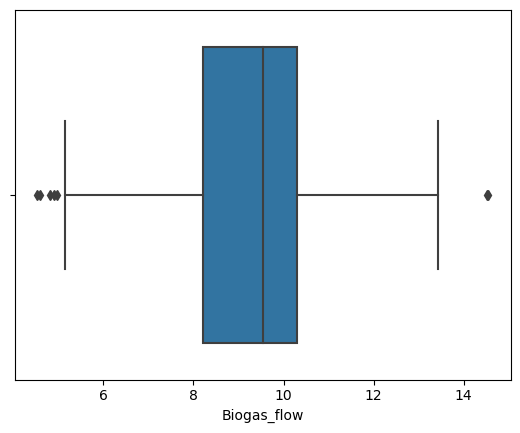

In [85]:
merged_Biogas1_3.describe()
sns.boxplot(x=merged_Biogas1_3['Biogas_flow'])

In [110]:
# Drop additional columns and assign to new variables X1 and y
X2 = merged_Biogas1_3.drop(['Date','Biogas_flow'], axis=1)
y2 = merged_Biogas1_3['Biogas_flow']

#Split data into train and test sets

test_size=0.25
random_seed = 42  # You can choose any integer as the seed
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=test_size, random_state=random_seed)
X_test.describe()

,TWAS_flow,pH_FS,VS_FS,T_FS,FS_flow
count,82.000000,82.000000,82.000000,82.000000,82.000000
mean,4.981766,5.809756,4.475793,17.316463,5.446658
std,1.457952,0.387413,0.755302,2.408345,1.144131
min,2.531778,4.900000,2.275000,12.150000,1.704353
25%,4.044925,5.525000,4.038750,15.825000,4.896400
50%,4.685928,5.850000,4.492500,17.225000,5.566710
75%,5.834462,6.100000,5.030000,19.387500,6.116214
max,9.409230,6.550000,6.130000,22.700000,8.156589


In [111]:
#Model Development

regressor2 = xgb.XGBRegressor()


regressor2.fit(X_train,y_train)
y_pred = regressor2.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))

print (rmse_test)

1.4235089873515703


In [92]:
regressor2 = xgb.XGBRegressor(**grid_xgb2.best_params_)
regressor2.fit(X_train,y_train)
y_pred = regressor2.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))

print (rmse_test)

1.392402598932626


In [112]:
###  XGBoost Configuration  ####
from sklearn.model_selection import RandomizedSearchCV

parameters = {'objective':['reg:squarederror'],'booster':['gbtree'],
'learning_rate': [0.01,0.02,0.05,0.1,0.2],'max_depth': [3,5,7,10],
'min_child_weight': [10,15,20,25],'colsample_bytree': [0.8, 0.9, 1],
'n_estimators': [100,200,300,400,500],"reg_alpha" : [0.5,0.2,1],
"reg_lambda" : [2,3,5],"gamma" : [3]}
grid_xgb2 = RandomizedSearchCV(regressor2,parameters, cv=5, n_iter=10, scoring='neg_mean_absolute_error', verbose=3, n_jobs=12)

grid_xgb2.fit(X_train, y_train, verbose = 1)

# Accessing detailed results
cv_results_df = pd.DataFrame(grid_xgb2.cv_results_)

# Extracting standard deviation of RMSE for each fold
std_rmse = cv_results_df[['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].std(axis=1)

# Extracting correlation coefficients (assuming you want Pearson correlation)
correlation_coef = cv_results_df[['param_learning_rate', 'param_max_depth', 'param_min_child_weight', 'param_colsample_bytree', 'param_n_estimators']].corr()

# Print the results
print("Standard Deviation of RMSE for each fold:")
print(std_rmse)

print("\nCorrelation Coefficients:")
print(correlation_coef)

y_pred = grid_xgb2.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))


print(grid_xgb2.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Standard Deviation of RMSE for each fold:
0    0.107245
1    0.114547
2    0.119283
3    0.093050
4    0.107083
5    0.097663
6    0.108498
7    0.106808
8    0.109753
9    0.104933
dtype: float64

Correlation Coefficients:
Empty DataFrame
Columns: []
Index: []
{'reg_lambda': 2, 'reg_alpha': 0.5, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.02, 'gamma': 3, 'colsample_bytree': 0.8, 'booster': 'gbtree'}


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [113]:
paramss={'reg_lambda': 5, 'reg_alpha': 0.01, 'objective': 'reg:squarederror', 'n_estimators': 200,
         'min_child_weight': 13, 'max_depth':3, 'learning_rate': 0.49, 'gamma': 3, 'colsample_bytree': 1,
         'booster': 'gbtree'}
regressor2 = xgb.XGBRegressor(**paramss)


regressor2.fit(X_train,y_train)
y_pred = regressor2.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))

print (rmse_test)

1.336627285035954


paramss={'reg_lambda': 3, 'reg_alpha': 0.001, 'objective': 'reg:squarederror', 'n_estimators': 200,
         'min_child_weight': 12, 'max_depth':3, 'learning_rate': 0.3, 'gamma': 3, 'colsample_bytree': 1,
         'booster': 'gbtree'}


In [114]:
# Define the cross-validation method
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store scores
train_rmse_scores = []
test_rmse_scores = []
train_r2_scores = []
test_r2_scores = []

# Define your regressor
#regressor = XGBRegressor(random_state=42)

# Assuming X1 and y are properly defined as DataFrame and Series respectively
for train_index, test_index in cv.split(X2):
    X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
    y_train, y_test = y2.iloc[train_index], y2.iloc[test_index]
    
    # Train the model
    regressor2.fit(X_train, y_train)
    
    # Predict on training and test data
    y_train_pred = regressor2.predict(X_train)
    y_test_pred = regressor2.predict(X_test)
    
    # Calculate RMSE for training and test data
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    
    # Calculate R^2 for training and test data
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Print training and testing RMSE and R^2 scores
print(f'Training RMSE scores: {train_rmse_scores}')
print(f'Testing RMSE scores: {test_rmse_scores}')
print(f'Mean Training RMSE: {np.mean(train_rmse_scores)}')
print(f'Mean Testing RMSE: {np.mean(test_rmse_scores)}')
print(f'Training R^2 scores: {train_r2_scores}')
print(f'Testing R^2 scores: {test_r2_scores}')
print(f'Mean Training R^2: {np.mean(train_r2_scores)}')
print(f'Mean Testing R^2: {np.mean(test_r2_scores)}')

Training RMSE scores: [0.9274127374231131, 0.9728570366884525, 0.9327181286468312, 0.9920279331910753, 0.937989837892528]
Testing RMSE scores: [1.457444627269869, 0.9628724481137304, 1.2226439525733601, 1.114244790164861, 1.4259379381262858]
Mean Training RMSE: 0.9526011347684001
Mean Testing RMSE: 1.236628751249621
Training R^2 scores: [0.6601160191163058, 0.6690957593578779, 0.7052082921521072, 0.6345181534032898, 0.6620279414771939]
Testing R^2 scores: [0.39310751930634735, 0.5683475688227881, 0.15815965609550353, 0.565848568370918, 0.37140415010722483]
Mean Training R^2: 0.6661932331013549
Mean Testing R^2: 0.4113734925405564


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


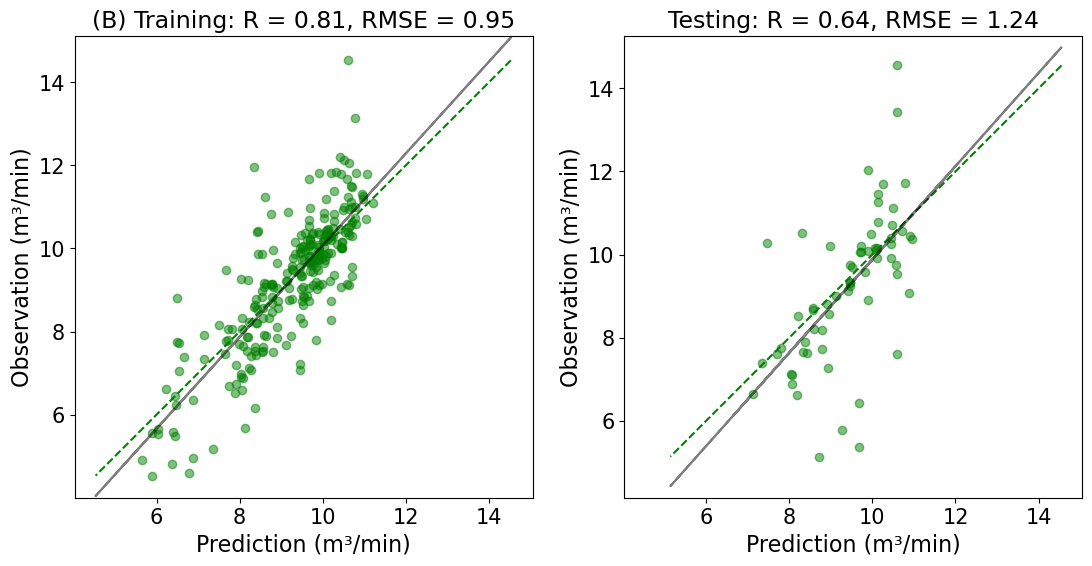

In [115]:
##PLot the results


# Calculate RMSE and R^2 values for training data
rmse_train = np.mean(train_rmse_scores)
r_train = np.sqrt(r2_score(y_train, y_train_pred))

# Calculate RMSE and R^2 values for testing data
rmse_test = np.mean(test_rmse_scores)
r_test = np.sqrt(np.mean(test_r2_scores))


##############   FIGURE  VISUALISATION  ##################
fig, (ax2,ax1)=plt.subplots(1,2,figsize=(13, 6),sharex=True)

ax2.scatter(y_train_pred, y_train, color='g' ,alpha = 0.5)

p1 = max(max(y_train_pred), max(y_train))
p2 = min(min(y_train_pred), min(y_train))
ax2.plot([p1,p2], [p1, p2], 'g--')


m2, b2 = np.polyfit(y_train_pred, y_train, 1)
ax2.plot(y_train, m2 * y_train + b2, color='k',linestyle='-', alpha = 0.5)

ax2.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax2.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax2.axis('equal')
ax2.set_title(f'(B) Training: R = {r_train:.2f}, RMSE = {rmse_train:.2f}' ,fontsize=17)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)


ax1.scatter(y_test_pred, y_test, color='g' ,alpha = 0.5)
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'g--')

m1, b1 = np.polyfit(y_test_pred, y_test, 1)
ax1.plot(y_test, m1 * y_test + b1, color='k',linestyle='-', alpha = 0.5)

ax1.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax1.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax1.axis('equal')
ax1.set_title(f'Testing: R = {r_test:.2f}, RMSE = {rmse_test:.2f}' ,fontsize=17)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)




fig.show()


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


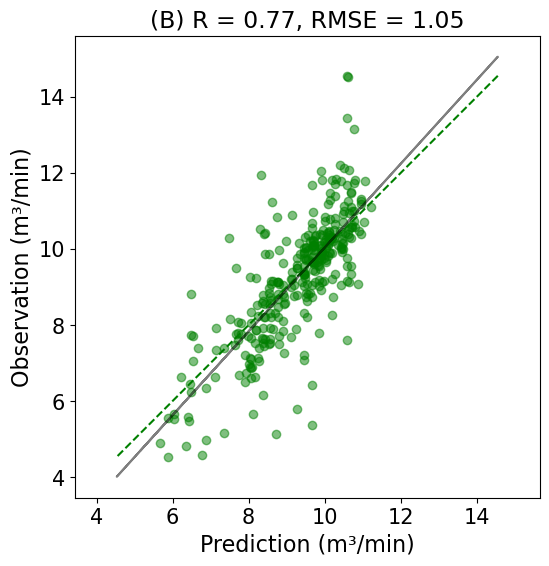

In [117]:
##PLot the results
y_pred_total2 = regressor2.predict(X2)

# Ensure y2 is float64
y2 = np.asarray(y2, dtype=np.float64)

# Ensure y_pred_total2 is float64
y_pred_total2 = np.asarray(y_pred_total2, dtype=np.float64)
# Calculate RMSE and R^2 values for training data
rmse_total2 = np.sqrt(mean_squared_error(y2, y_pred_total2))
r_total2 = np.sqrt(r2_score(y2, y_pred_total2))



##############   FIGURE  VISUALISATION  ##################
fig, (ax2)=plt.subplots(figsize=(6, 6),sharex=True)

ax2.scatter(y_pred_total2, y2, color='g',alpha = 0.5)

p1 = max(max(y_pred_total2), np.max(y2))
p2 = min(min(y_pred_total2), np.min(y2))
ax2.plot([p1,p2], [p1, p2], 'g--')


m2, b2 = np.polyfit(y_pred_total2, y2, 1)
ax2.plot(y2, m2 * y2 + b2, color='k',linestyle='-', alpha = 0.5)

ax2.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax2.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax2.axis('equal')
ax2.set_title(f'(B) R = {r_total2:.2f}, RMSE = {rmse_total2:.2f}' ,fontsize=17)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

fig.show()



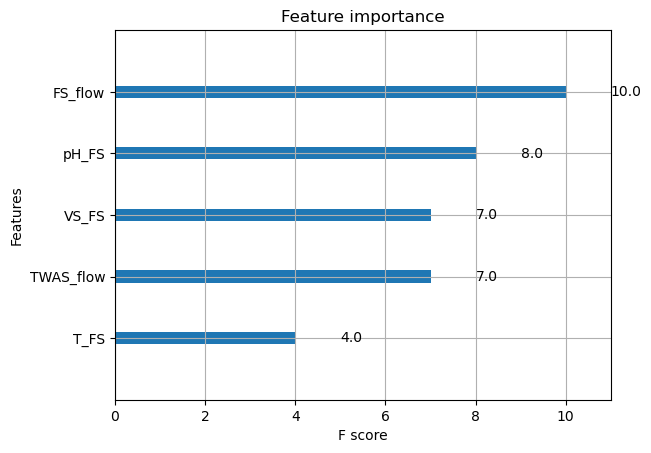

In [118]:
xgb.plot_importance(regressor2)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


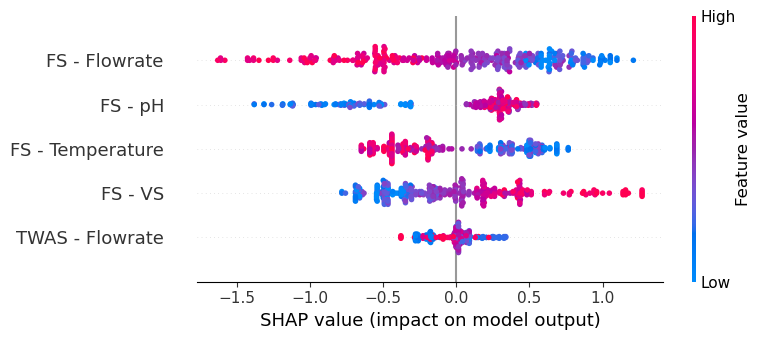

<Figure size 640x480 with 0 Axes>

In [120]:
# SHAP Analysis
custom_feature_names = [ "TWAS - Flowrate", "FS - pH","FS - VS","FS - Temperature", "FS - Flowrate"]  # Replace with your actual feature names


explainer = shap.TreeExplainer(regressor2)
shap_values = explainer.shap_values(X2)

# Summary plot
shap.summary_plot(shap_values, X2, feature_names=custom_feature_names)
plt.savefig('shap_summary_plot.png', dpi=1000, bbox_inches='tight')


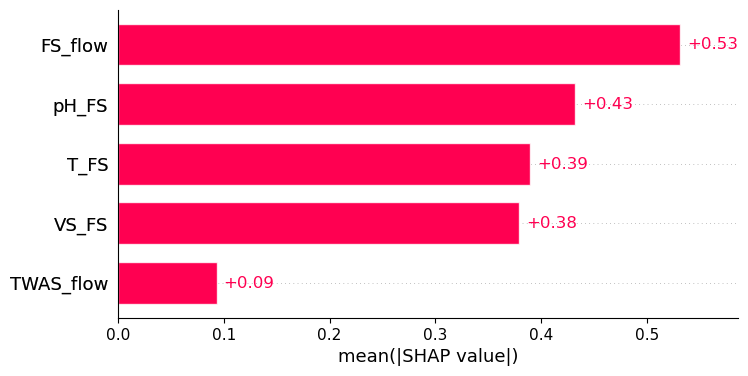

In [122]:
# Create the TreeExplainer and compute SHAP values
explainer = shap.Explainer(regressor2)
shap_values = explainer(X2)

# Now shap_values is an Explanation object, which can be directly used with plotting functions
shap.plots.bar(shap_values)

## Optimization with BOA

In [952]:
# Define the bounds for all the parameters to be optimized
pbounds = {'FS_flow': (1.0, 8.2),'TWAS_flow': (2.4, 11.03),
    'pH_FS': (4.75, 6.7),
    'VS_FS': (0.34, 6.9),'T_FS': (11.95, 21.7)}


# Define the optimization function with all parameters
def optimize_biogas(TWAS_flow, pH_FS, VS_FS, T_FS, FS_flow):
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({'TWAS_flow': [TWAS_flow],
                               'pH_FS': [pH_FS], 'VS_FS': [VS_FS],
                               'T_FS': [T_FS],'FS_flow': [FS_flow]})

    # Use the trained XGBoost model to predict biogas production
    biogas_production = regressor2.predict(input_data)

    # Return the negative of biogas production since Bayesian Optimization aims to minimize
    return biogas_production[0]

# Initialize the optimizer with updated parameters
optimizer = BayesianOptimization(f=optimize_biogas, pbounds=pbounds, random_state=42)


# Perform the optimization
optimizer.maximize(init_points=5, n_iter=1500)

# Extract and print the results
results_df_combined2 = pd.DataFrame(optimizer.res, columns=['params', 'target'])
print(optimizer.max)


# Extract other parameters in the results DataFrame
def extract_params(params_dict):
    return [params_dict[param] for param in pbounds.keys()]

# Apply the extract_params function to the 'params' column
results_df_combined2[list(pbounds.keys())] = results_df_combined2['params'].apply(extract_params).apply(pd.Series)

# Drop the 'params' column
results_df_combined2.drop('params', axis=1, inplace=True)

results_df_combined2

|   iter    |  target   |  FS_flow  | TWAS_flow |   T_FS    |   VS_FS   |   pH_FS   |
-------------------------------------------------------------------------------------
| 1         | 9.373     | 3.697     | 10.6      | 19.09     | 4.267     | 5.054     |
| 2         | 10.07     | 2.123     | 2.901     | 20.4      | 4.283     | 6.131     |
| 3         | 8.469     | 1.148     | 10.77     | 20.07     | 1.733     | 5.105     |
| 4         | 8.022     | 2.321     | 5.026     | 17.07     | 3.174     | 5.318     |
| 5         | 9.138     | 5.405     | 3.604     | 14.8      | 2.743     | 5.639     |
| 6         | 9.384     | 5.742     | 3.052     | 14.81     | 2.742     | 5.761     |
| 7         | 10.96     | 2.06      | 2.4       | 21.68     | 4.716     | 6.448     |
| 8         | 11.57     | 1.098     | 2.4       | 21.7      | 6.9       | 6.7       |
| 9         | 8.532     | 5.991     | 2.4       | 21.7      | 6.9       | 6.7       |
| 10        | 10.59     | 1.435     | 4.927     | 21.6

| 58        | 11.41     | 3.368     | 2.4       | 16.56     | 6.9       | 6.7       |
| 59        | 11.57     | 1.0       | 2.4       | 21.7      | 6.374     | 6.7       |
| 60        | 11.57     | 1.423     | 2.4       | 17.74     | 6.9       | 6.144     |
| 61        | 10.99     | 1.0       | 2.4       | 21.7      | 6.9       | 4.75      |
| 62        | 11.4      | 1.0       | 9.968     | 20.85     | 6.9       | 6.7       |
| 63        | 10.84     | 2.877     | 2.4       | 16.11     | 6.9       | 4.75      |
| 64        | 11.57     | 1.345     | 2.4       | 17.92     | 6.9       | 6.7       |
| 65        | 11.32     | 1.0       | 3.312     | 21.7      | 6.9       | 6.7       |
| 66        | 10.99     | 1.0       | 2.4       | 18.26     | 6.9       | 4.75      |
| 67        | 11.24     | 1.0       | 9.405     | 13.61     | 6.9       | 6.7       |
| 68        | 11.4      | 1.0       | 6.565     | 20.39     | 6.9       | 6.7       |
| 69        | 11.4      | 3.555     | 9.227     | 18.4

| 116       | 11.38     | 4.73      | 7.83      | 17.57     | 6.9       | 6.7       |
| 117       | 11.4      | 3.882     | 8.263     | 20.44     | 6.9       | 6.7       |
| 118       | 11.57     | 1.0       | 2.4       | 17.46     | 6.015     | 6.7       |
| 119       | 11.57     | 1.236     | 2.422     | 16.65     | 5.788     | 6.134     |
| 120       | 10.8      | 1.0       | 2.4       | 15.23     | 4.827     | 6.7       |
| 121       | 11.24     | 2.165     | 9.669     | 15.62     | 6.9       | 6.7       |
| 122       | 11.39     | 1.082     | 2.488     | 16.66     | 6.165     | 5.87      |
| 123       | 11.57     | 2.581     | 2.4       | 17.01     | 5.501     | 6.7       |
| 124       | 10.8      | 1.573     | 2.429     | 16.53     | 5.329     | 6.696     |
| 125       | 8.408     | 8.2       | 11.03     | 21.7      | 0.34      | 6.7       |
| 126       | 10.77     | 2.754     | 2.4       | 17.54     | 5.495     | 5.535     |
| 127       | 9.055     | 1.0       | 7.914     | 11.9

| 174       | 9.747     | 4.645     | 7.251     | 21.7      | 3.897     | 6.7       |
| 175       | 11.24     | 2.944     | 4.417     | 13.72     | 6.9       | 6.7       |
| 176       | 11.4      | 4.071     | 9.682     | 19.91     | 6.243     | 6.7       |
| 177       | 11.4      | 3.481     | 6.344     | 21.7      | 6.172     | 6.7       |
| 178       | 11.4      | 1.0       | 9.906     | 19.23     | 6.213     | 6.7       |
| 179       | 11.06     | 4.847     | 2.4       | 11.95     | 6.9       | 6.7       |
| 180       | 11.4      | 3.715     | 4.654     | 19.89     | 6.31      | 6.7       |
| 181       | 11.24     | 1.0       | 5.069     | 15.13     | 6.9       | 6.7       |
| 182       | 11.4      | 1.0       | 6.119     | 19.02     | 5.759     | 6.7       |
| 183       | 11.4      | 4.12      | 5.706     | 17.76     | 6.9       | 6.7       |
| 184       | 11.24     | 1.0       | 6.309     | 13.53     | 6.9       | 6.7       |
| 185       | 11.4      | 1.0       | 11.03     | 17.5

| 232       | 11.47     | 4.679     | 4.076     | 17.51     | 6.322     | 6.7       |
| 233       | 11.4      | 4.208     | 4.887     | 18.44     | 5.893     | 6.7       |
| 234       | 11.24     | 4.135     | 4.516     | 16.31     | 6.9       | 6.7       |
| 235       | 10.95     | 5.23      | 5.325     | 17.2      | 5.955     | 6.7       |
| 236       | 11.24     | 3.101     | 9.827     | 11.95     | 5.715     | 6.7       |
| 237       | 10.63     | 5.233     | 8.506     | 16.53     | 6.172     | 6.7       |
| 238       | 11.4      | 2.666     | 4.211     | 19.18     | 5.884     | 6.7       |
| 239       | 10.59     | 1.0       | 11.03     | 21.7      | 6.9       | 5.181     |
| 240       | 11.57     | 4.264     | 3.218     | 18.09     | 6.139     | 6.7       |
| 241       | 11.24     | 2.699     | 7.707     | 15.55     | 6.9       | 6.7       |
| 242       | 11.4      | 3.837     | 7.279     | 17.05     | 6.07      | 6.7       |
| 243       | 11.4      | 1.567     | 11.03     | 18.3

| 290       | 9.545     | 1.0       | 6.955     | 21.7      | 0.34      | 6.7       |
| 291       | 11.4      | 1.0       | 9.403     | 21.7      | 6.9       | 6.7       |
| 292       | 11.23     | 5.027     | 11.03     | 18.99     | 6.029     | 6.7       |
| 293       | 11.4      | 1.0       | 4.2       | 19.47     | 5.548     | 6.7       |
| 294       | 10.79     | 1.0       | 11.03     | 21.7      | 4.715     | 6.7       |
| 295       | 11.4      | 4.497     | 6.643     | 17.49     | 6.658     | 6.7       |
| 296       | 11.4      | 3.548     | 4.767     | 20.73     | 5.527     | 6.7       |
| 297       | 10.34     | 1.0       | 8.714     | 14.33     | 4.061     | 6.7       |
| 298       | 11.24     | 1.0       | 9.178     | 16.31     | 6.9       | 6.7       |
| 299       | 11.32     | 2.52      | 3.465     | 20.6      | 6.17      | 6.7       |
| 300       | 11.41     | 2.458     | 2.4       | 13.19     | 5.514     | 6.7       |
| 301       | 11.24     | 1.78      | 6.175     | 16.1

| 348       | 10.73     | 4.881     | 11.03     | 11.95     | 6.9       | 6.7       |
| 349       | 11.32     | 4.19      | 3.286     | 16.84     | 6.9       | 6.7       |
| 350       | 10.21     | 1.0       | 2.4       | 21.7      | 5.065     | 4.75      |
| 351       | 11.24     | 1.0       | 2.4       | 14.6      | 6.9       | 5.834     |
| 352       | 11.4      | 1.0       | 11.03     | 21.7      | 6.066     | 6.7       |
| 353       | 11.24     | 3.259     | 11.03     | 12.85     | 6.056     | 6.7       |
| 354       | 11.4      | 1.913     | 10.27     | 19.66     | 5.75      | 6.7       |
| 355       | 11.4      | 3.051     | 5.276     | 19.5      | 6.372     | 6.7       |
| 356       | 11.57     | 2.275     | 2.4       | 18.93     | 6.9       | 6.7       |
| 357       | 11.32     | 3.979     | 3.833     | 17.59     | 6.325     | 6.7       |
| 358       | 11.57     | 4.397     | 2.4       | 19.09     | 6.9       | 6.7       |
| 359       | 10.64     | 5.187     | 3.242     | 18.4

| 406       | 8.421     | 1.0       | 2.4       | 18.04     | 0.34      | 4.75      |
| 407       | 10.12     | 1.0       | 7.942     | 16.49     | 0.34      | 6.7       |
| 408       | 10.95     | 5.242     | 4.353     | 16.74     | 6.9       | 6.7       |
| 409       | 9.044     | 1.0       | 11.03     | 16.24     | 0.34      | 4.75      |
| 410       | 10.13     | 1.0       | 5.108     | 11.95     | 0.34      | 6.7       |
| 411       | 11.4      | 4.398     | 5.863     | 18.75     | 6.262     | 6.7       |
| 412       | 11.17     | 2.279     | 3.475     | 14.66     | 6.9       | 6.7       |
| 413       | 11.66     | 2.304     | 4.102     | 18.78     | 6.9       | 6.7       |
| 414       | 11.32     | 2.224     | 3.781     | 18.34     | 6.9       | 6.7       |
| 415       | 6.594     | 8.2       | 6.552     | 21.7      | 6.9       | 4.75      |
| 416       | 11.24     | 1.0       | 4.66      | 16.4      | 6.245     | 6.7       |
| 417       | 11.23     | 4.932     | 10.36     | 20.5

| 464       | 11.24     | 3.259     | 2.4       | 15.35     | 5.948     | 5.931     |
| 465       | 10.66     | 1.0       | 9.214     | 16.15     | 5.765     | 4.75      |
| 466       | 11.41     | 1.652     | 2.4       | 14.48     | 6.9       | 6.7       |
| 467       | 11.4      | 4.383     | 7.026     | 21.7      | 6.099     | 6.7       |
| 468       | 10.44     | 3.407     | 11.03     | 13.88     | 6.9       | 5.551     |
| 469       | 11.57     | 1.624     | 2.4       | 20.06     | 5.878     | 6.7       |
| 470       | 11.4      | 2.186     | 4.301     | 19.16     | 6.45      | 6.668     |
| 471       | 11.24     | 1.752     | 10.15     | 16.17     | 5.917     | 6.7       |
| 472       | 11.4      | 1.0       | 5.906     | 19.44     | 6.9       | 6.7       |
| 473       | 10.63     | 1.0       | 4.191     | 13.61     | 5.138     | 6.7       |
| 474       | 11.24     | 3.707     | 7.027     | 14.74     | 6.9       | 6.7       |
| 475       | 11.57     | 4.261     | 2.851     | 17.7

| 522       | 10.21     | 3.438     | 2.4       | 21.7      | 5.068     | 4.75      |
| 523       | 11.24     | 3.427     | 8.597     | 15.13     | 5.82      | 6.7       |
| 524       | 11.17     | 3.215     | 3.408     | 11.95     | 5.992     | 6.7       |
| 525       | 11.57     | 2.618     | 2.4       | 21.19     | 5.554     | 6.7       |
| 526       | 11.24     | 4.136     | 5.085     | 12.98     | 5.925     | 6.7       |
| 527       | 10.82     | 3.496     | 5.366     | 19.74     | 6.9       | 4.75      |
| 528       | 11.24     | 3.802     | 10.36     | 11.95     | 6.317     | 6.7       |
| 529       | 10.82     | 2.178     | 5.673     | 13.53     | 6.9       | 5.647     |
| 530       | 11.22     | 3.758     | 6.764     | 19.32     | 6.11      | 5.884     |
| 531       | 10.3      | 1.0       | 2.4       | 13.54     | 3.245     | 6.7       |
| 532       | 11.37     | 4.55      | 2.4       | 18.25     | 6.9       | 5.995     |
| 533       | 11.4      | 4.13      | 5.273     | 18.8

| 580       | 11.2      | 4.522     | 4.903     | 20.7      | 5.697     | 6.7       |
| 581       | 11.4      | 1.784     | 7.742     | 19.98     | 6.9       | 6.7       |
| 582       | 11.4      | 3.988     | 10.42     | 21.7      | 6.289     | 6.7       |
| 583       | 11.4      | 1.465     | 6.656     | 18.35     | 6.155     | 6.7       |
| 584       | 11.57     | 4.045     | 2.794     | 20.25     | 6.177     | 6.417     |
| 585       | 11.4      | 3.25      | 5.405     | 18.21     | 6.031     | 6.077     |
| 586       | 11.4      | 4.022     | 11.03     | 19.29     | 6.121     | 6.7       |
| 587       | 11.24     | 1.0       | 8.476     | 14.87     | 6.9       | 6.7       |
| 588       | 11.4      | 1.0       | 4.306     | 18.91     | 6.229     | 6.7       |
| 589       | 11.4      | 1.0       | 8.862     | 20.79     | 6.9       | 6.7       |
| 590       | 11.4      | 3.722     | 5.351     | 18.74     | 6.512     | 6.7       |
| 591       | 11.4      | 3.519     | 5.576     | 20.2

| 638       | 11.4      | 3.878     | 7.658     | 19.59     | 6.9       | 6.7       |
| 639       | 11.41     | 3.014     | 2.4       | 13.86     | 6.036     | 6.7       |
| 640       | 11.22     | 3.15      | 6.269     | 20.22     | 6.9       | 5.912     |
| 641       | 11.24     | 3.307     | 4.294     | 13.01     | 6.08      | 6.7       |
| 642       | 11.4      | 1.0       | 5.929     | 18.12     | 6.26      | 6.7       |
| 643       | 11.24     | 1.0       | 5.665     | 16.07     | 6.9       | 6.7       |
| 644       | 11.23     | 4.649     | 11.03     | 13.37     | 5.928     | 6.7       |
| 645       | 11.4      | 1.0       | 10.31     | 16.86     | 6.9       | 6.7       |
| 646       | 11.22     | 3.552     | 8.155     | 20.11     | 5.928     | 5.961     |
| 647       | 11.38     | 4.634     | 9.108     | 20.49     | 6.9       | 6.7       |
| 648       | 11.4      | 1.0       | 7.61      | 16.94     | 6.9       | 6.7       |
| 649       | 11.41     | 1.851     | 3.104     | 12.7

| 696       | 11.4      | 3.212     | 5.684     | 17.58     | 6.9       | 6.7       |
| 697       | 11.57     | 3.525     | 2.886     | 18.09     | 6.126     | 6.611     |
| 698       | 11.57     | 1.503     | 2.46      | 21.68     | 6.169     | 6.518     |
| 699       | 11.4      | 3.669     | 5.377     | 20.27     | 6.006     | 6.7       |
| 700       | 11.24     | 2.927     | 5.455     | 16.15     | 6.105     | 6.7       |
| 701       | 11.4      | 2.602     | 8.825     | 20.13     | 5.977     | 6.7       |
| 702       | 11.4      | 2.07      | 5.792     | 19.06     | 6.9       | 6.7       |
| 703       | 11.4      | 3.171     | 5.7       | 19.39     | 5.782     | 6.0       |
| 704       | 11.24     | 1.0       | 5.678     | 14.41     | 6.287     | 6.7       |
| 705       | 11.4      | 4.282     | 9.231     | 18.9      | 6.271     | 6.7       |
| 706       | 11.57     | 1.0       | 2.4       | 21.18     | 6.9       | 6.338     |
| 707       | 11.57     | 1.0       | 2.4       | 18.7

| 754       | 11.57     | 2.018     | 2.416     | 20.14     | 6.296     | 6.416     |
| 755       | 11.24     | 4.197     | 4.383     | 15.65     | 6.111     | 6.7       |
| 756       | 11.24     | 1.966     | 7.259     | 12.55     | 6.9       | 6.7       |
| 757       | 11.24     | 4.354     | 6.249     | 16.55     | 6.093     | 6.7       |
| 758       | 11.57     | 3.988     | 2.683     | 16.68     | 6.346     | 6.7       |
| 759       | 11.57     | 3.968     | 2.4       | 19.47     | 6.9       | 6.506     |
| 760       | 11.57     | 2.115     | 3.157     | 16.98     | 6.309     | 6.429     |
| 761       | 11.57     | 2.421     | 2.789     | 17.23     | 5.737     | 6.588     |
| 762       | 11.57     | 2.06      | 2.473     | 18.49     | 6.509     | 6.264     |
| 763       | 11.4      | 3.929     | 5.336     | 20.96     | 6.9       | 6.7       |
| 764       | 11.57     | 3.594     | 2.4       | 20.5      | 6.9       | 6.7       |
| 765       | 11.57     | 1.613     | 2.4       | 19.8

| 812       | 11.4      | 4.001     | 5.156     | 17.93     | 6.165     | 6.272     |
| 813       | 11.41     | 1.42      | 2.4       | 12.57     | 6.9       | 6.7       |
| 814       | 11.57     | 2.339     | 2.4       | 18.64     | 6.1       | 6.297     |
| 815       | 11.57     | 2.996     | 2.613     | 19.94     | 6.51      | 6.542     |
| 816       | 11.57     | 2.325     | 2.928     | 16.81     | 6.9       | 6.7       |
| 817       | 11.57     | 4.432     | 2.746     | 17.25     | 6.523     | 6.41      |
| 818       | 11.57     | 4.111     | 2.924     | 19.77     | 6.9       | 6.119     |
| 819       | 11.4      | 3.127     | 11.03     | 19.51     | 6.9       | 6.7       |
| 820       | 11.13     | 1.0       | 5.785     | 17.89     | 5.446     | 6.7       |
| 821       | 10.79     | 2.6       | 9.62      | 19.1      | 5.3       | 6.7       |
| 822       | 11.4      | 1.0       | 7.393     | 21.7      | 6.357     | 6.7       |
| 823       | 11.57     | 4.452     | 2.4       | 19.8

| 870       | 11.57     | 3.848     | 2.4       | 21.35     | 6.9       | 5.988     |
| 871       | 11.15     | 3.862     | 2.56      | 21.67     | 6.499     | 5.681     |
| 872       | 11.4      | 4.052     | 7.422     | 20.68     | 6.9       | 6.081     |
| 873       | 11.57     | 2.708     | 2.71      | 17.19     | 6.9       | 6.346     |
| 874       | 11.57     | 1.658     | 2.4       | 18.08     | 6.421     | 6.439     |
| 875       | 11.57     | 2.848     | 2.812     | 21.28     | 6.651     | 6.445     |
| 876       | 11.57     | 2.111     | 2.698     | 17.13     | 6.466     | 6.392     |
| 877       | 11.4      | 3.701     | 8.402     | 19.22     | 6.056     | 6.7       |
| 878       | 11.57     | 1.0       | 2.4       | 21.07     | 6.9       | 6.7       |
| 879       | 11.57     | 2.655     | 2.726     | 20.49     | 6.029     | 6.624     |
| 880       | 11.57     | 4.035     | 2.727     | 17.19     | 6.519     | 6.579     |
| 881       | 11.37     | 4.567     | 2.944     | 17.4

| 928       | 11.57     | 2.045     | 2.4       | 19.72     | 5.889     | 6.398     |
| 929       | 11.66     | 2.233     | 4.072     | 18.47     | 6.438     | 6.647     |
| 930       | 11.57     | 1.363     | 2.4       | 17.15     | 6.9       | 6.327     |
| 931       | 11.41     | 2.738     | 2.4       | 15.17     | 6.9       | 6.7       |
| 932       | 11.57     | 1.0       | 2.914     | 20.61     | 6.9       | 6.7       |
| 933       | 11.57     | 4.231     | 2.4       | 16.67     | 6.9       | 6.362     |
| 934       | 11.66     | 2.356     | 4.047     | 18.62     | 6.8       | 6.498     |
| 935       | 10.98     | 4.636     | 2.4       | 20.3      | 6.9       | 4.75      |
| 936       | 11.22     | 1.0       | 9.399     | 17.43     | 5.65      | 5.966     |
| 937       | 11.57     | 3.69      | 3.158     | 19.55     | 6.254     | 6.324     |
| 938       | 11.41     | 2.597     | 2.4       | 12.65     | 6.9       | 6.7       |
| 939       | 11.4      | 3.083     | 5.397     | 17.3

| 986       | 11.57     | 1.794     | 2.81      | 21.33     | 6.9       | 6.415     |
| 987       | 11.4      | 1.0       | 9.339     | 21.08     | 6.196     | 6.7       |
| 988       | 11.57     | 2.038     | 2.4       | 19.03     | 5.695     | 6.547     |
| 989       | 11.4      | 3.636     | 7.185     | 20.32     | 6.9       | 6.7       |
| 990       | 11.57     | 4.037     | 2.766     | 18.87     | 6.756     | 6.682     |
| 991       | 11.57     | 3.994     | 2.651     | 20.14     | 6.9       | 6.39      |
| 992       | 11.57     | 2.399     | 2.4       | 18.43     | 6.9       | 6.435     |
| 993       | 11.4      | 4.158     | 6.135     | 18.72     | 6.9       | 6.7       |
| 994       | 11.57     | 4.025     | 2.97      | 18.75     | 6.9       | 6.225     |
| 995       | 11.4      | 3.745     | 7.236     | 21.7      | 6.166     | 6.7       |
| 996       | 11.57     | 4.325     | 2.724     | 19.31     | 6.9       | 6.273     |
| 997       | 11.57     | 3.347     | 2.4       | 17.8

| 1044      | 11.57     | 1.024     | 2.931     | 19.71     | 6.313     | 6.221     |
| 1045      | 11.57     | 1.022     | 2.954     | 18.85     | 6.862     | 6.485     |
| 1046      | 11.4      | 3.153     | 9.201     | 17.22     | 5.587     | 6.7       |
| 1047      | 11.57     | 1.0       | 2.839     | 18.3      | 6.9       | 6.358     |
| 1048      | 11.15     | 1.01      | 3.633     | 19.12     | 6.502     | 5.879     |
| 1049      | 11.57     | 3.236     | 2.87      | 19.64     | 6.9       | 6.7       |
| 1050      | 11.57     | 1.536     | 2.4       | 20.51     | 5.675     | 6.431     |
| 1051      | 11.31     | 2.954     | 2.55      | 19.59     | 5.459     | 6.053     |
| 1052      | 11.24     | 2.997     | 8.918     | 15.04     | 6.9       | 6.7       |
| 1053      | 8.188     | 8.2       | 6.611     | 21.7      | 2.217     | 6.7       |
| 1054      | 11.24     | 3.221     | 9.668     | 11.95     | 6.9       | 6.7       |
| 1055      | 11.57     | 1.001     | 2.807     | 20.0

| 1102      | 6.732     | 8.2       | 6.274     | 16.71     | 3.376     | 4.75      |
| 1103      | 7.233     | 5.975     | 11.03     | 21.7      | 3.714     | 4.75      |
| 1104      | 11.32     | 3.746     | 3.727     | 17.87     | 5.981     | 6.521     |
| 1105      | 10.59     | 3.814     | 4.66      | 17.42     | 5.952     | 5.394     |
| 1106      | 11.14     | 5.111     | 11.03     | 21.7      | 6.9       | 6.7       |
| 1107      | 10.79     | 4.15      | 5.17      | 16.68     | 5.363     | 6.368     |
| 1108      | 11.06     | 3.976     | 6.134     | 15.13     | 6.9       | 5.792     |
| 1109      | 10.7      | 1.0       | 8.509     | 11.95     | 4.27      | 6.7       |
| 1110      | 11.4      | 1.0       | 6.48      | 20.94     | 6.9       | 5.994     |
| 1111      | 11.24     | 3.001     | 7.961     | 13.01     | 6.9       | 6.7       |
| 1112      | 11.22     | 4.181     | 7.866     | 17.14     | 6.9       | 5.949     |
| 1113      | 9.625     | 5.644     | 11.03     | 11.9

| 1160      | 10.82     | 4.113     | 9.497     | 16.17     | 5.51      | 5.681     |
| 1161      | 11.4      | 3.485     | 6.474     | 17.73     | 6.136     | 6.236     |
| 1162      | 11.57     | 1.0       | 3.022     | 20.34     | 6.09      | 5.992     |
| 1163      | 11.4      | 3.136     | 5.269     | 17.33     | 5.91      | 6.7       |
| 1164      | 11.4      | 4.325     | 7.568     | 17.45     | 5.876     | 6.02      |
| 1165      | 9.885     | 3.381     | 4.677     | 11.95     | 5.123     | 4.75      |
| 1166      | 11.21     | 4.804     | 8.02      | 17.9      | 6.336     | 5.949     |
| 1167      | 11.66     | 1.762     | 4.06      | 18.21     | 6.563     | 6.318     |
| 1168      | 11.4      | 1.799     | 11.03     | 21.7      | 6.296     | 6.183     |
| 1169      | 11.4      | 3.622     | 9.792     | 21.11     | 5.905     | 6.445     |
| 1170      | 11.22     | 3.68      | 7.822     | 18.29     | 5.811     | 5.951     |
| 1171      | 11.57     | 3.949     | 2.821     | 18.2

| 1218      | 11.4      | 3.52      | 5.906     | 18.71     | 6.362     | 6.052     |
| 1219      | 11.4      | 1.688     | 11.03     | 18.77     | 6.9       | 6.143     |
| 1220      | 11.4      | 1.898     | 9.11      | 20.75     | 6.9       | 6.271     |
| 1221      | 11.24     | 1.0       | 8.207     | 15.97     | 6.337     | 6.7       |
| 1222      | 11.57     | 1.618     | 2.4       | 19.14     | 6.492     | 6.7       |
| 1223      | 11.4      | 2.205     | 6.114     | 18.01     | 6.141     | 6.123     |
| 1224      | 11.4      | 1.734     | 9.596     | 17.61     | 6.316     | 6.181     |
| 1225      | 11.4      | 3.933     | 9.085     | 17.68     | 5.688     | 6.7       |
| 1226      | 11.4      | 4.407     | 8.146     | 18.41     | 6.9       | 6.7       |
| 1227      | 11.57     | 1.0       | 2.758     | 17.72     | 5.856     | 6.48      |
| 1228      | 11.41     | 1.0       | 2.4       | 14.47     | 6.9       | 6.7       |
| 1229      | 11.4      | 4.157     | 10.29     | 20.6

| 1276      | 11.4      | 3.086     | 8.537     | 18.97     | 6.9       | 6.7       |
| 1277      | 11.4      | 3.524     | 11.03     | 17.15     | 6.101     | 6.105     |
| 1278      | 11.4      | 2.377     | 5.559     | 20.0      | 6.497     | 6.314     |
| 1279      | 11.4      | 1.51      | 8.235     | 21.69     | 6.105     | 6.149     |
| 1280      | 11.57     | 4.362     | 2.4       | 19.82     | 6.375     | 6.363     |
| 1281      | 11.4      | 2.619     | 7.597     | 17.3      | 5.869     | 6.33      |
| 1282      | 11.57     | 2.492     | 2.968     | 16.89     | 6.266     | 6.7       |
| 1283      | 11.57     | 1.876     | 2.717     | 17.27     | 5.949     | 5.998     |
| 1284      | 11.4      | 1.576     | 11.03     | 18.43     | 6.9       | 6.7       |
| 1285      | 11.4      | 1.0       | 5.999     | 20.66     | 6.518     | 6.43      |
| 1286      | 11.4      | 1.585     | 5.116     | 20.15     | 6.9       | 6.7       |
| 1287      | 11.4      | 2.738     | 6.102     | 17.4

| 1334      | 10.82     | 4.517     | 2.4       | 16.13     | 6.9       | 4.75      |
| 1335      | 11.22     | 1.0       | 11.03     | 19.46     | 6.021     | 5.945     |
| 1336      | 11.4      | 1.579     | 8.409     | 20.42     | 5.76      | 6.66      |
| 1337      | 10.28     | 4.944     | 9.382     | 17.32     | 5.073     | 6.7       |
| 1338      | 11.4      | 1.103     | 6.586     | 21.66     | 5.915     | 6.035     |
| 1339      | 10.97     | 1.0       | 7.43      | 21.7      | 6.047     | 5.684     |
| 1340      | 11.4      | 1.96      | 7.853     | 20.97     | 6.092     | 6.249     |
| 1341      | 11.24     | 4.0       | 9.677     | 14.81     | 6.9       | 6.7       |
| 1342      | 11.24     | 3.821     | 9.051     | 11.95     | 6.058     | 6.7       |
| 1343      | 11.4      | 3.071     | 6.64      | 18.35     | 5.495     | 6.7       |
| 1344      | 10.99     | 4.087     | 3.908     | 11.95     | 6.9       | 5.783     |
| 1345      | 11.4      | 3.546     | 7.128     | 17.5

| 1392      | 10.34     | 1.0       | 11.03     | 14.39     | 3.924     | 6.7       |
| 1393      | 10.96     | 1.75      | 2.4       | 17.84     | 5.159     | 6.7       |
| 1394      | 11.24     | 2.242     | 7.149     | 15.58     | 6.039     | 6.7       |
| 1395      | 11.4      | 1.0       | 6.567     | 21.7      | 5.902     | 6.7       |
| 1396      | 11.66     | 2.375     | 4.097     | 18.6      | 6.489     | 6.266     |
| 1397      | 10.99     | 1.712     | 2.4       | 13.48     | 6.099     | 5.732     |
| 1398      | 11.41     | 4.0       | 2.4       | 14.69     | 5.901     | 6.131     |
| 1399      | 11.41     | 1.0       | 2.893     | 12.34     | 5.96      | 6.103     |
| 1400      | 10.95     | 5.096     | 6.12      | 21.7      | 5.925     | 6.7       |
| 1401      | 11.4      | 2.358     | 4.21      | 21.7      | 6.315     | 6.121     |
| 1402      | 11.24     | 4.123     | 11.03     | 12.66     | 5.962     | 6.7       |
| 1403      | 11.17     | 2.246     | 3.558     | 16.4

| 1450      | 11.4      | 4.495     | 10.21     | 21.7      | 6.9       | 6.115     |
| 1451      | 11.17     | 1.553     | 3.326     | 12.77     | 5.656     | 6.139     |
| 1452      | 11.4      | 1.944     | 7.105     | 17.02     | 5.883     | 6.7       |
| 1453      | 11.32     | 2.083     | 3.327     | 20.29     | 6.233     | 6.186     |
| 1454      | 10.8      | 1.696     | 2.4       | 13.35     | 5.081     | 6.427     |
| 1455      | 10.82     | 3.017     | 4.29      | 21.7      | 6.9       | 4.75      |
| 1456      | 11.41     | 1.0       | 2.4       | 16.31     | 6.9       | 6.7       |
| 1457      | 10.06     | 1.0       | 3.806     | 11.95     | 2.728     | 6.7       |
| 1458      | 11.4      | 4.408     | 10.88     | 19.48     | 6.243     | 6.077     |
| 1459      | 11.4      | 3.174     | 5.806     | 20.43     | 6.9       | 6.7       |
| 1460      | 11.4      | 2.536     | 4.271     | 18.06     | 6.9       | 6.7       |
| 1461      | 11.66     | 2.276     | 4.099     | 18.2

,target,FS_flow,TWAS_flow,pH_FS,VS_FS,T_FS
0,9.373197,3.696689,10.604664,5.054236,4.267200,19.086941
1,10.069921,2.123161,2.901262,6.130742,4.283314,20.395217
2,8.469039,1.148208,10.770322,5.104559,1.732945,20.066316
3,8.022215,2.320512,5.025611,5.317897,3.173559,17.066375
4,9.138341,5.405341,3.603832,5.639336,2.743334,14.798410
...,...,...,...,...,...,...
1500,11.166471,3.443872,3.943477,6.700000,6.900000,12.459755
1501,11.568126,3.005164,2.700170,6.589645,5.879801,20.017161
1502,11.411870,4.282136,2.400000,6.700000,6.134438,14.549560
1503,11.239642,1.330081,4.440016,6.611936,6.193440,15.253893


In [953]:
results_df_combined2.describe()

,target,FS_flow,TWAS_flow,pH_FS,VS_FS,T_FS
count,1505.000000,1505.000000,1505.000000,1505.000000,1505.000000,1505.000000
mean,11.190417,2.776376,5.902296,6.393520,6.137187,17.762672
std,0.639607,1.455723,3.033645,0.499660,1.149611,2.937651
min,6.106520,1.000000,2.400000,4.750000,0.340000,11.950000
25%,11.239642,1.552170,2.809791,6.189939,5.915430,16.102894
50%,11.395898,2.698129,5.397130,6.700000,6.288714,18.211497
75%,11.411870,3.851685,8.610127,6.700000,6.900000,20.139401
max,11.663933,8.200000,11.030000,6.700000,6.900000,21.700000


In [954]:
## A dataframe with Biogas > 10
limit = 10 # average biogas production rate from the plant
new_results_df_combined2 = results_df_combined2[results_df_combined2['target'] > limit]
new_results_df_combined2.reset_index(drop=True,inplace = True)


# add new columns to new dataframe
new_results_df_combined2 = new_results_df_combined2.assign(FS_percent =new_results_df_combined2['FS_flow']/(new_results_df_combined2['TWAS_flow']+
                                       new_results_df_combined2['FS_flow']),
                                       TWAS_percent =new_results_df_combined2['TWAS_flow']/(new_results_df_combined2['TWAS_flow']+
                                       new_results_df_combined2['FS_flow']))

new_results_df_combined2 = new_results_df_combined2.assign(FS_TWAS =new_results_df_combined2['FS_flow']/
                                                           new_results_df_combined2['TWAS_flow'])

new_results_df_combined2 ###Mixing ratios
new_results_df_combined2.describe()


,target,FS_flow,TWAS_flow,pH_FS,VS_FS,T_FS,FS_percent,TWAS_percent,FS_TWAS
count,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000
mean,11.304634,2.660204,5.855140,6.430600,6.288065,17.828921,0.335709,0.664291,0.601730
std,0.290796,1.241627,3.004761,0.435914,0.745176,2.877543,0.152359,0.152359,0.435970
min,10.041028,1.000000,2.400000,4.750000,0.340000,11.950000,0.083126,0.311020,0.090662
25%,11.239642,1.546774,2.810053,6.224626,5.952296,16.275235,0.223764,0.557148,0.288268
50%,11.395898,2.640146,5.350619,6.700000,6.312631,18.261070,0.316110,0.683890,0.462223
75%,11.411870,3.767893,8.534363,6.700000,6.900000,20.139482,0.442852,0.776236,0.794854
max,11.663933,5.481727,11.030000,6.700000,6.900000,21.700000,0.688980,0.916874,2.215225


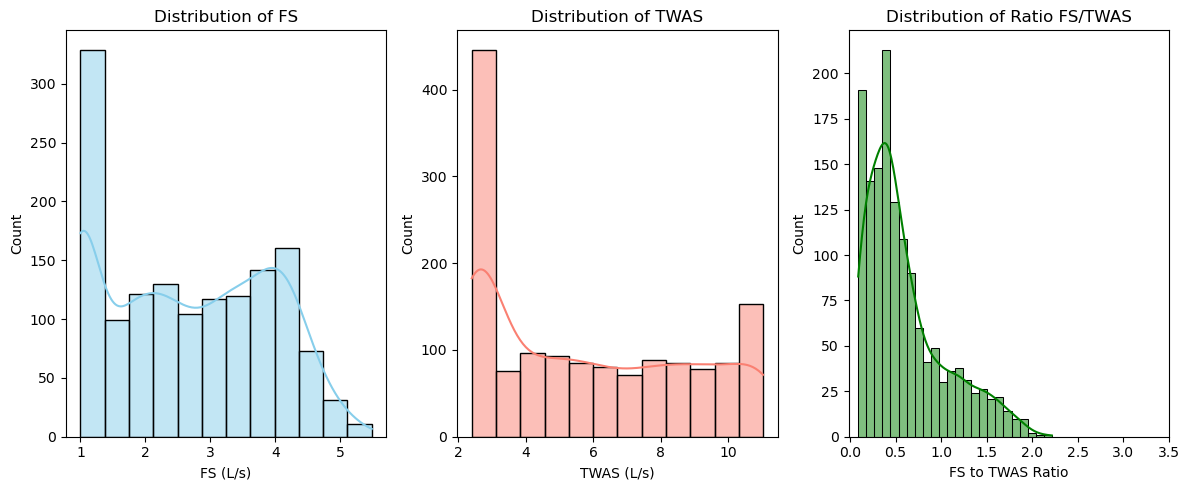

In [955]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.histplot(new_results_df_combined2['FS_flow'], kde=True, color='skyblue')
plt.title('Distribution of FS')
plt.xlabel('FS (L/s)')


plt.subplot(1, 3, 2)
sns.histplot(new_results_df_combined2['TWAS_flow'], kde=True, color='salmon')
plt.title('Distribution of TWAS')
plt.xlabel('TWAS (L/s)')


plt.subplot(1, 3, 3)
sns.histplot(new_results_df_combined2['FS_TWAS'], kde=True, color='green')
plt.title('Distribution of Ratio FS/TWAS')
plt.xticks(np.arange(0, 4, 0.5)) 
plt.xlabel('FS to TWAS Ratio')


plt.tight_layout()
plt.show()

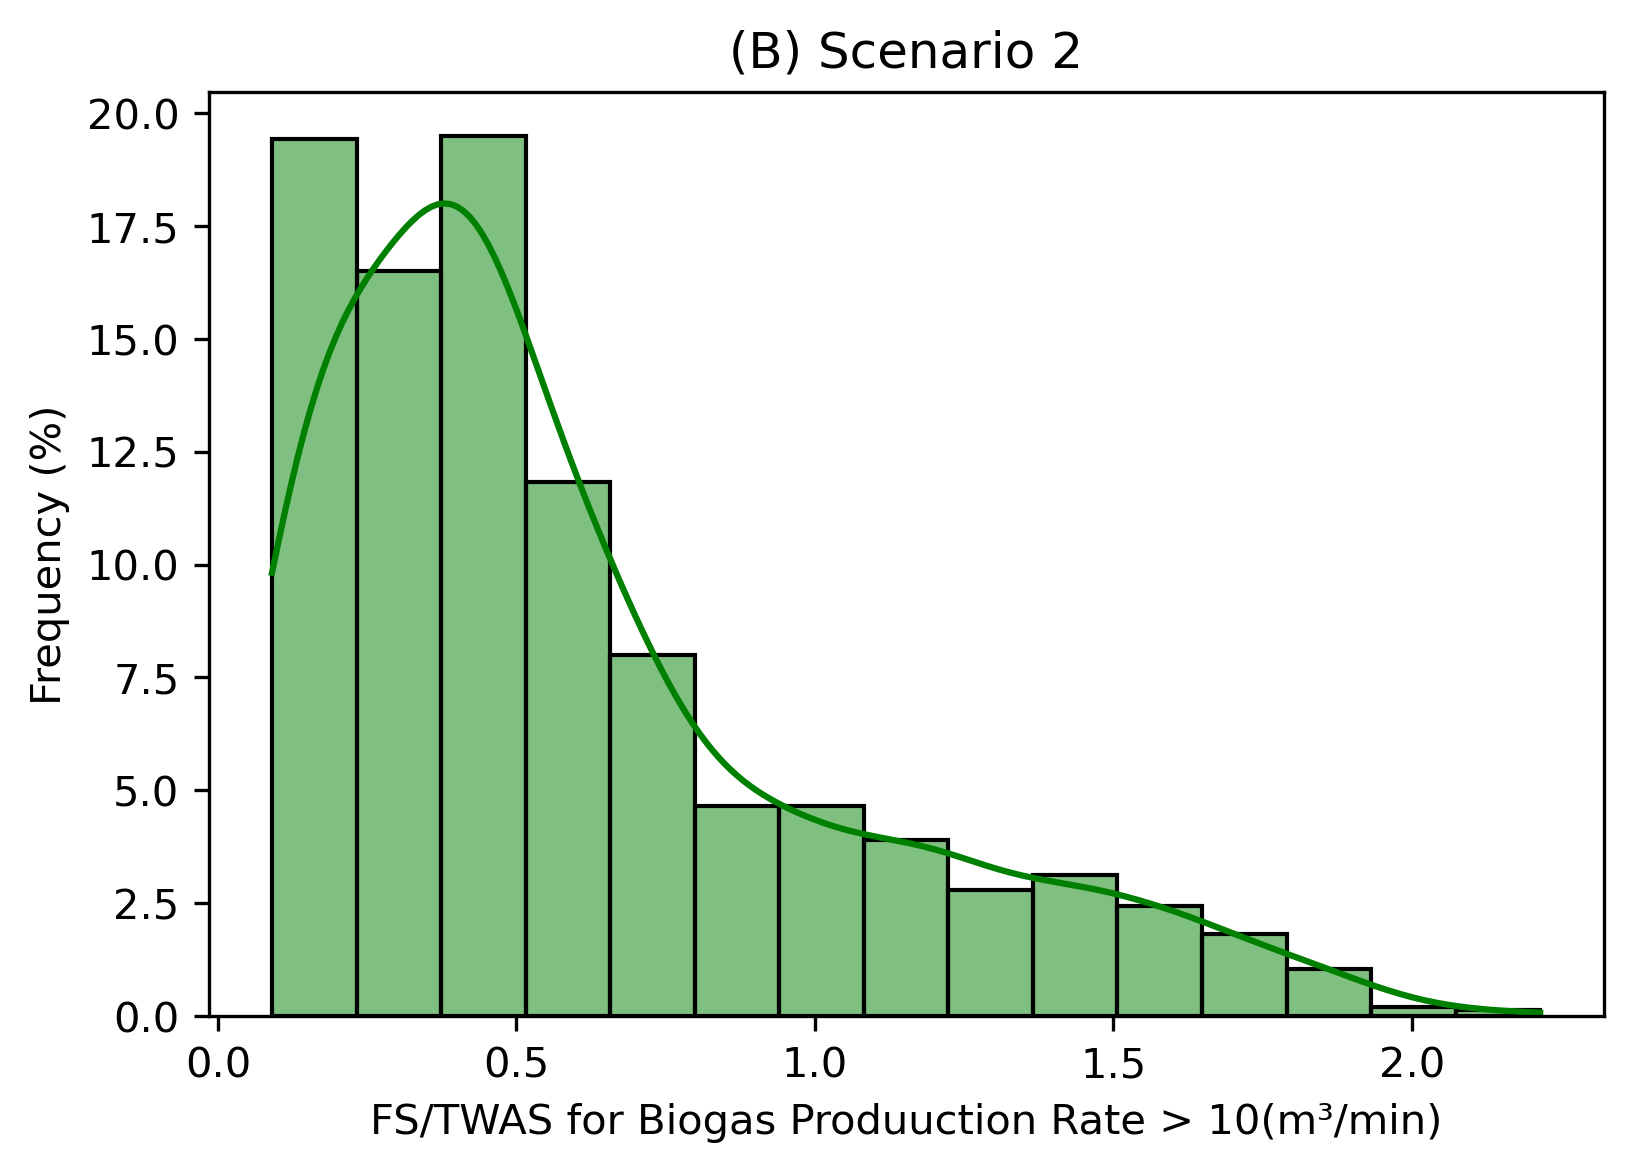

In [956]:
# Plot the histogram
# Increase figure size and set higher DPI
plt.figure(figsize=(6, 4), dpi=300)
sns.histplot(new_results_df_combined2['FS_TWAS'], bins=15, kde=True, color='g',  stat='percent')
plt.title('(B) Scenario 2')
plt.xlabel('FS/TWAS for Biogas Produuction Rate > 10(m\u00b3/min)')
plt.ylabel('Frequency (%)')
plt.grid(False)
plt.show()